In [1]:
#Import all necessary libraries
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap
import torch
from tabulate import tabulate
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.init import kaiming_normal_
from IPython.display import clear_output

In [2]:
# Set random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# Cell 2: Load and display dataset
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [4]:
print("Dataset shape ::", diabetes_df.shape)

Dataset shape :: (768, 9)


In [5]:
print("\nClass distribution:")
print(diabetes_df['Outcome'].value_counts())


Class distribution:
0    500
1    268
Name: Outcome, dtype: int64


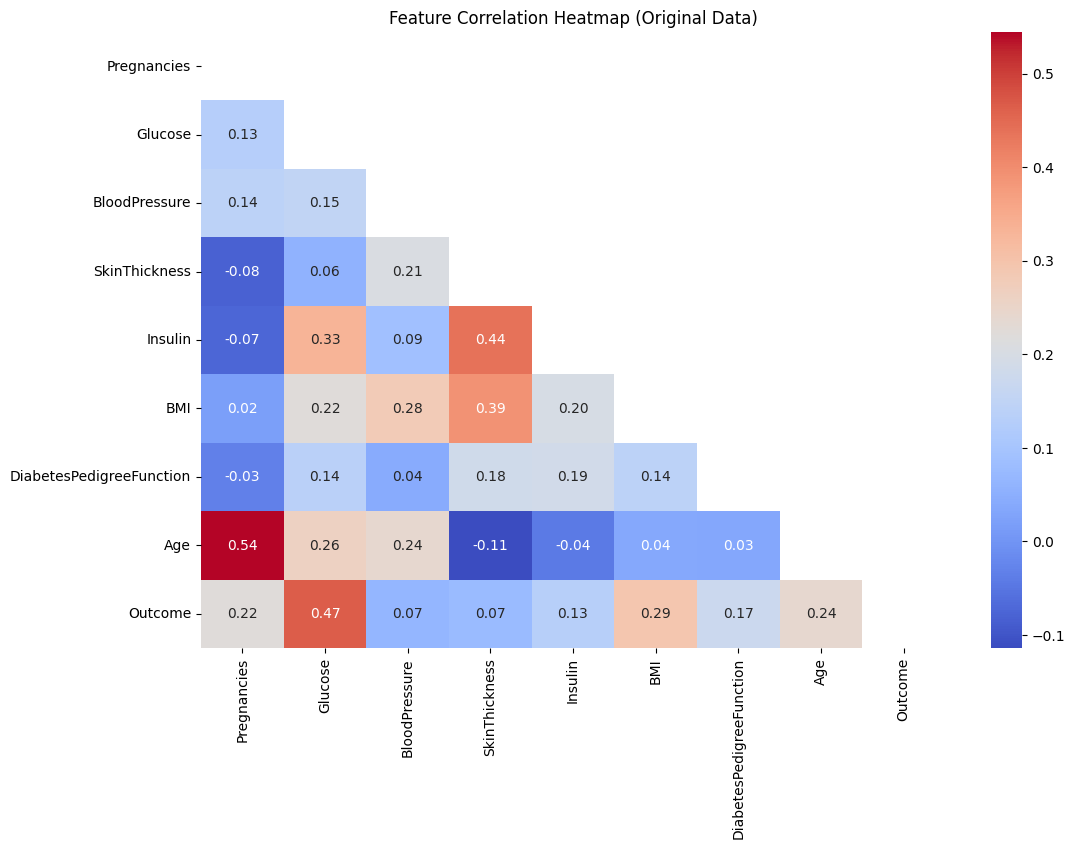

In [6]:
# Cell 3a: Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = diabetes_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title('Feature Correlation Heatmap (Original Data)')
plt.show()

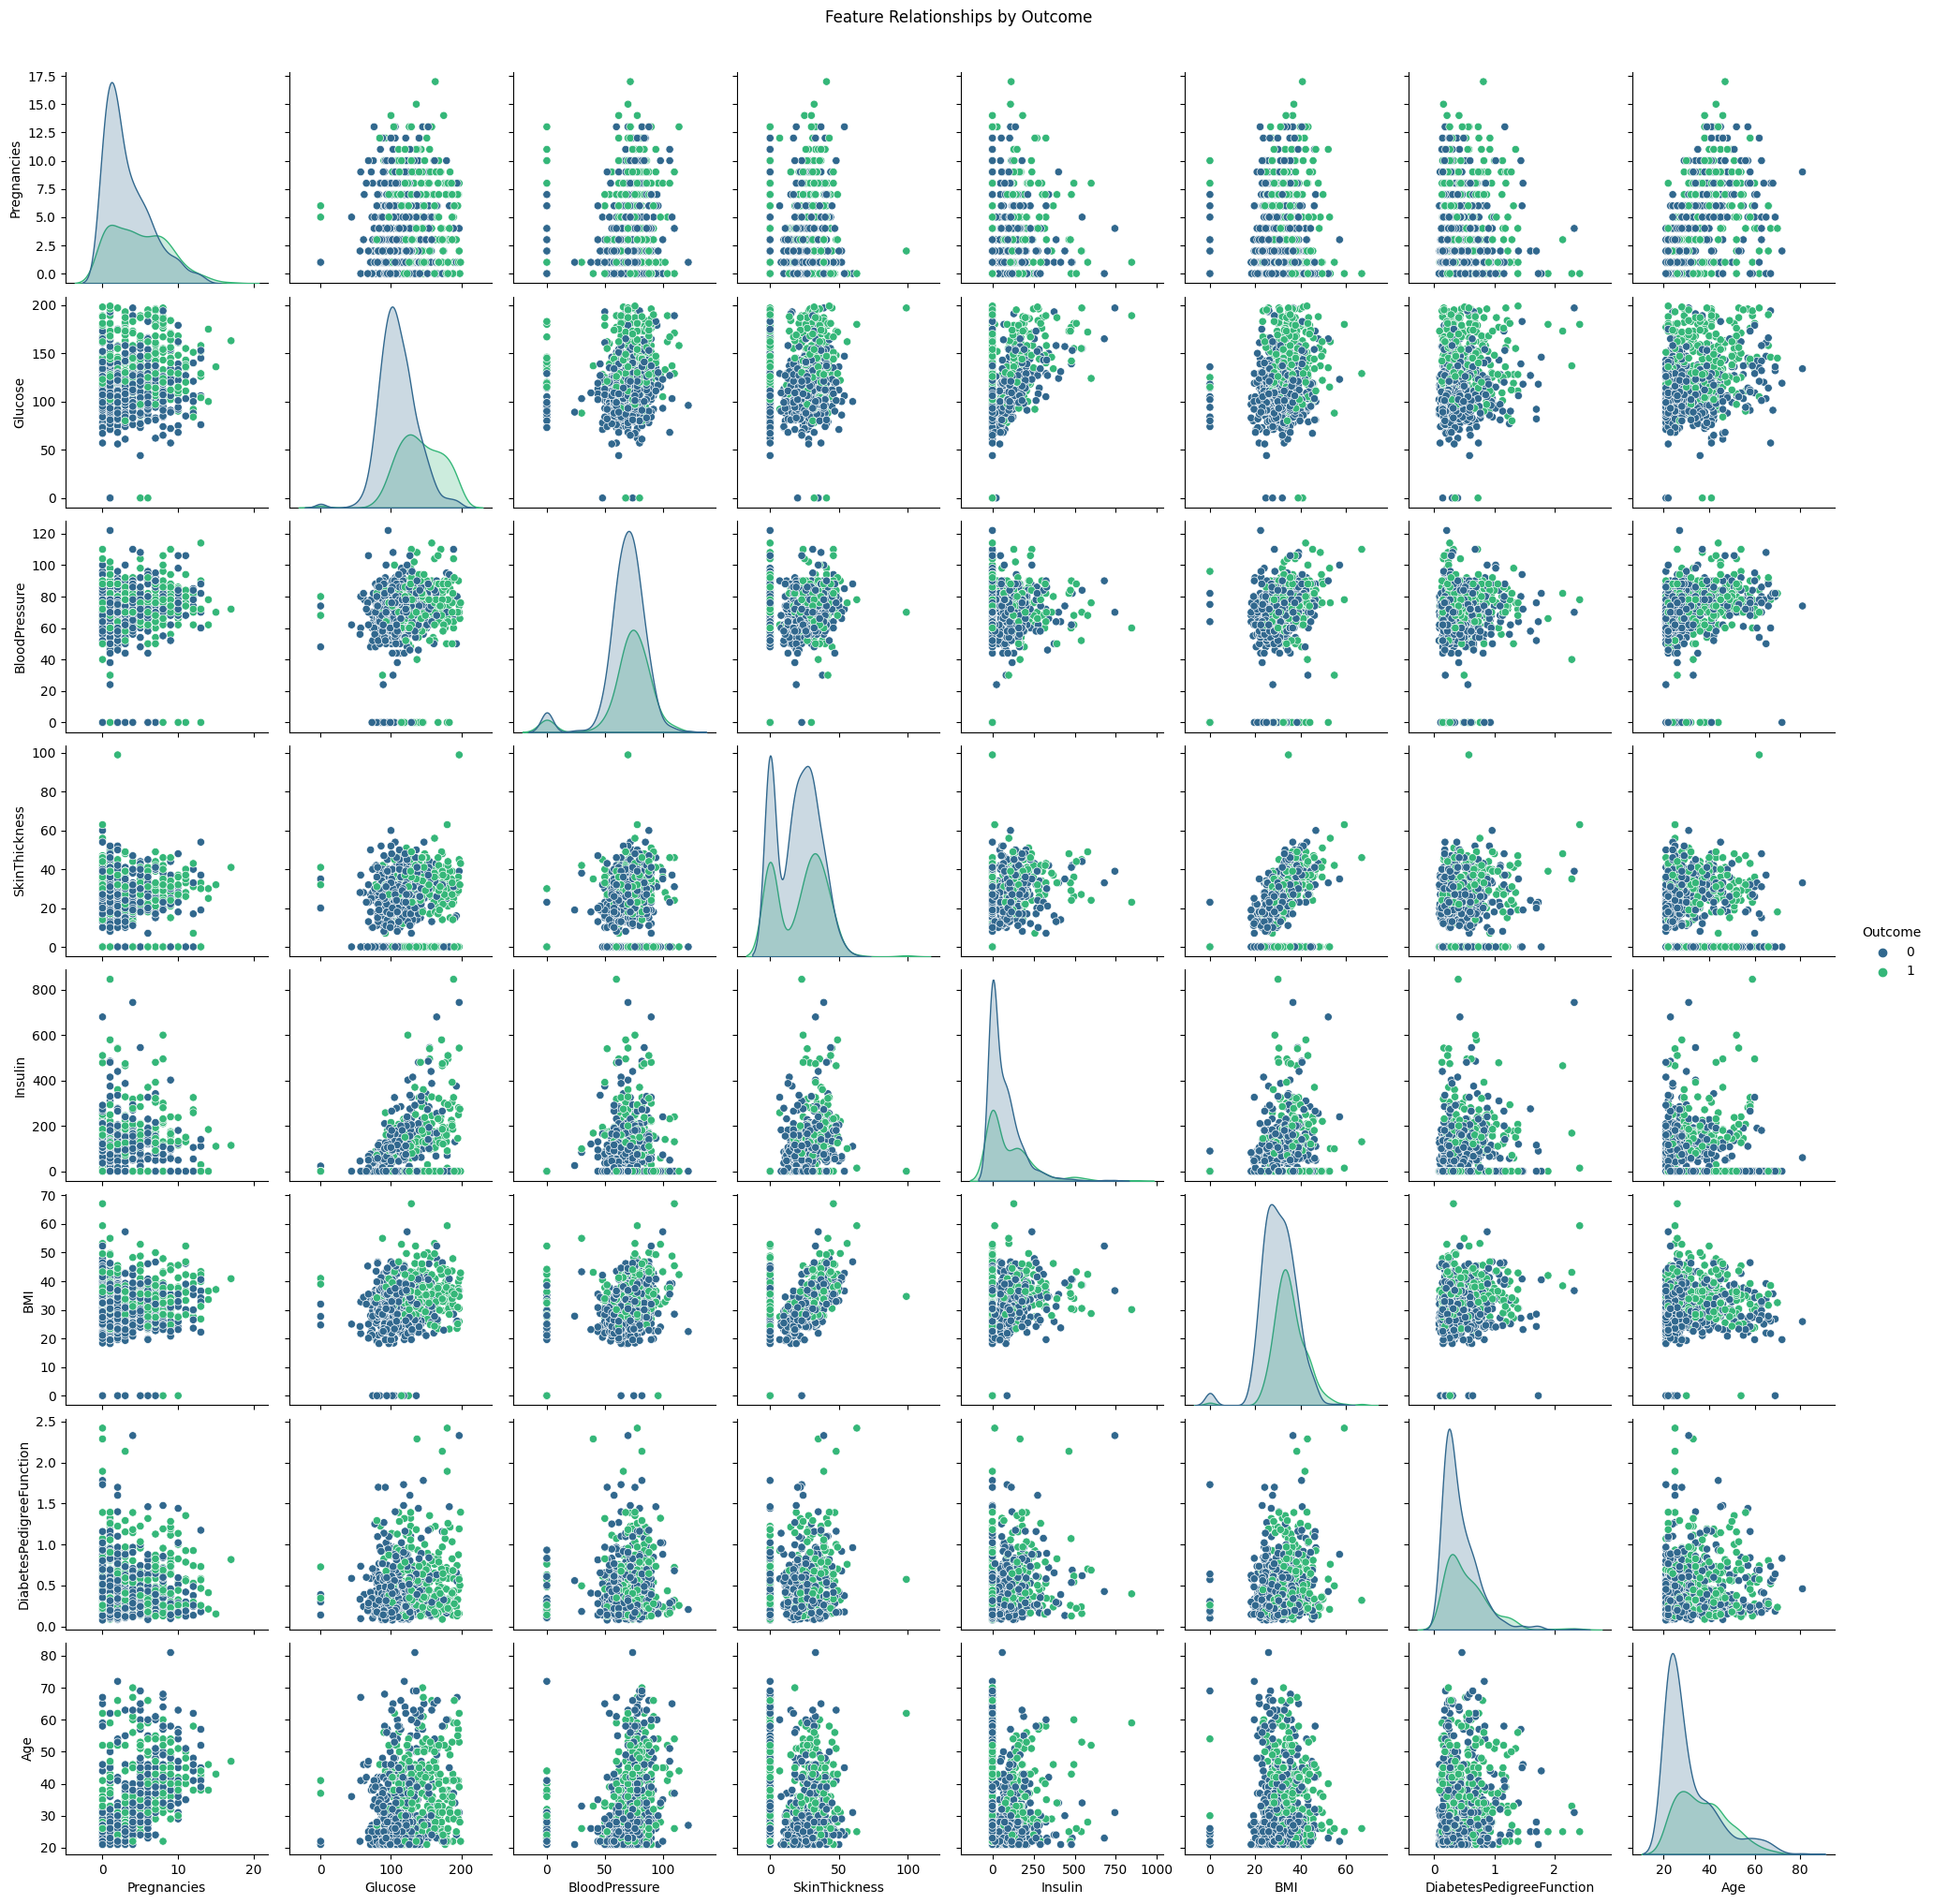

In [7]:
# # Cell 3b: Pairplot of Selected Features
sns.pairplot(diabetes_df, hue='Outcome', palette='viridis')
plt.suptitle('Feature Relationships by Outcome', y=1.02)
plt.show()

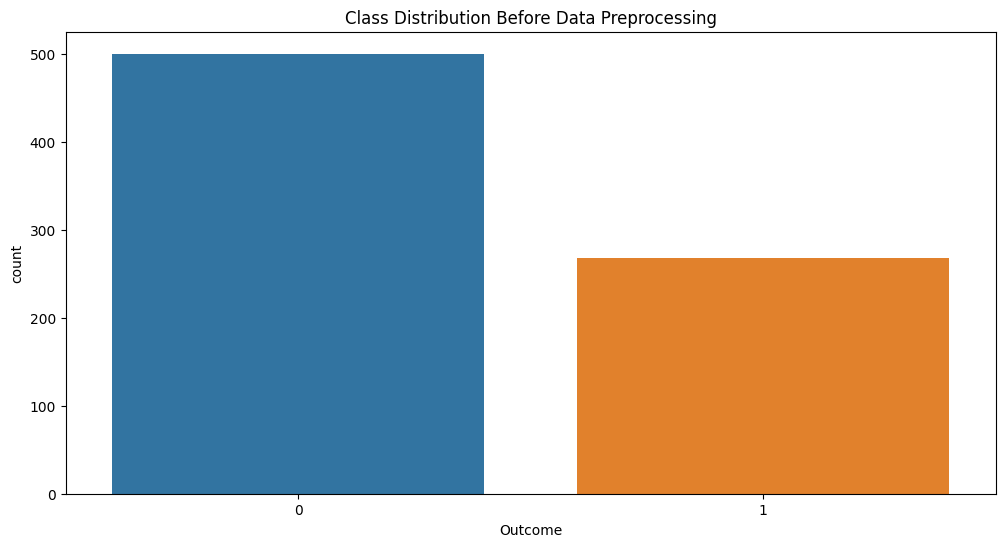

In [8]:
# Preprocessing visualization
# Before preprocessing plots
plt.figure(figsize=(12, 6))
sns.countplot(x='Outcome', data=diabetes_df)
plt.title('Class Distribution Before Data Preprocessing')
plt.show()

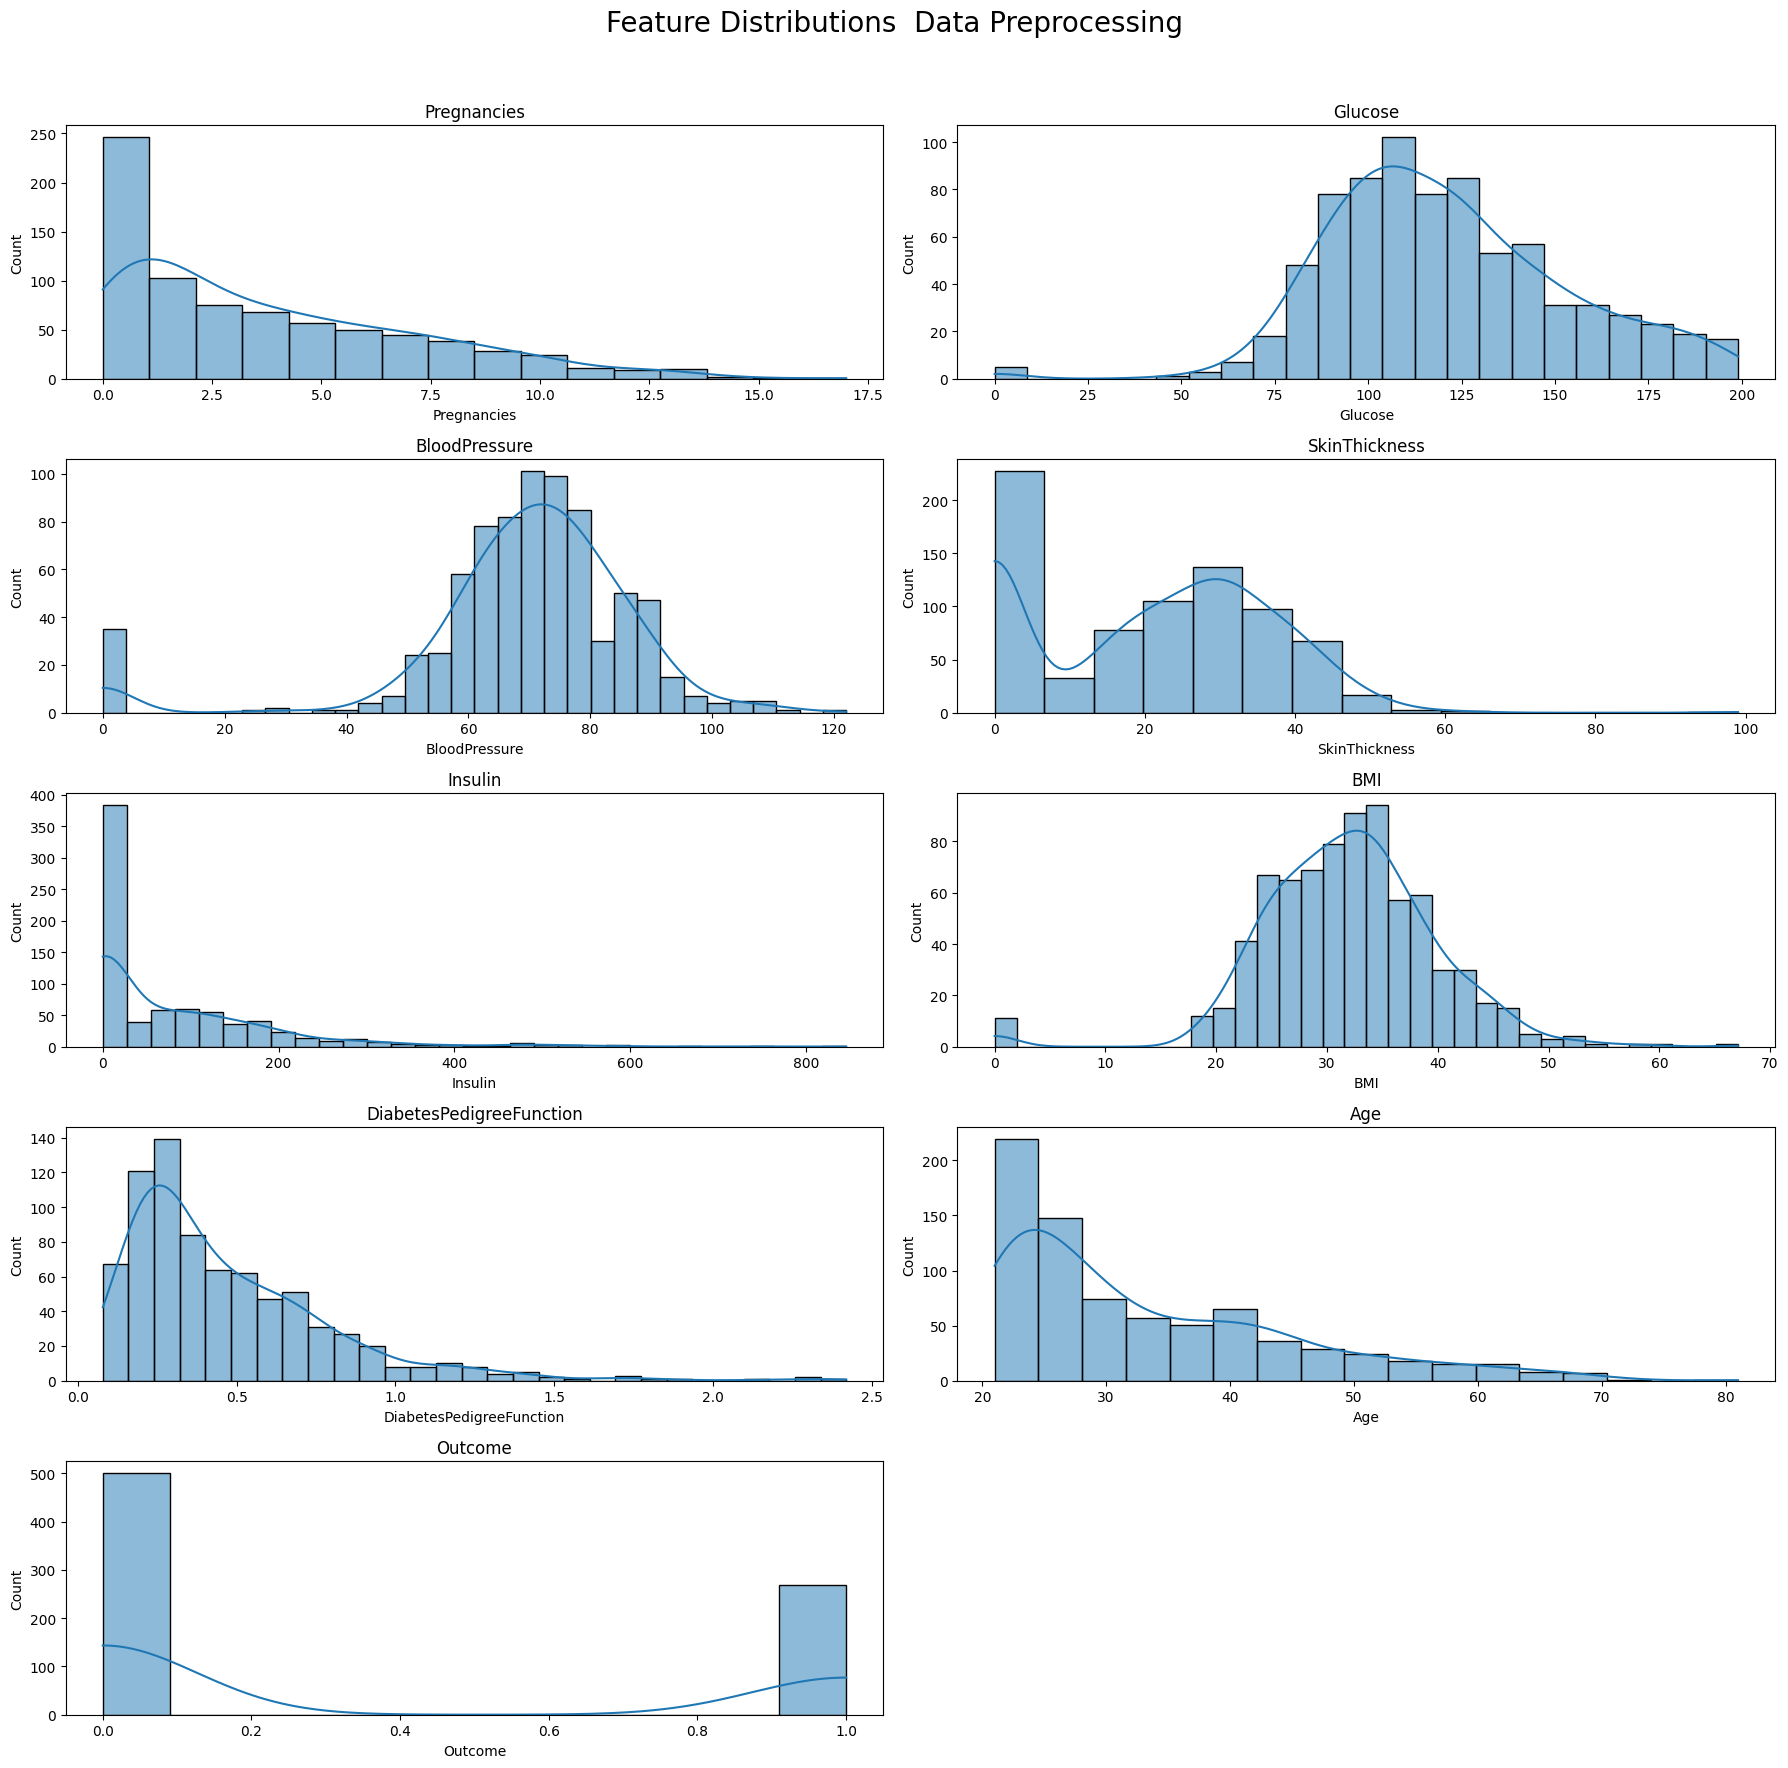

In [9]:
import math
plt.figure(figsize=(18, 18))

num_cols = len(diabetes_df.columns)
num_rows = math.ceil(num_cols / 2)  # 2 plots per row

for i, col in enumerate(diabetes_df.columns):
    plt.subplot(num_rows, 2, i + 1)
    sns.histplot(diabetes_df[col], kde=True)
    plt.title(col)

plt.suptitle('Feature Distributions  Data Preprocessing', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

In [10]:
# Cell 4: Data preprocessing
# Handle missing values
data = diabetes_df.copy()
for col in ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Insulin']:
    data[col] = data[col].replace(0, np.nan)
    data[col] = data.groupby('Outcome')[col].transform(lambda x: x.fillna(x.median()))

# Apply SMOTE
X = data.drop('Outcome', axis=1)
y = data['Outcome']
smote = SMOTE(random_state=SEED)
X_res, y_res = smote.fit_resample(X, y)

# StandardScaler normalization
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_res)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)
X_normalized

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0       0.631479  0.707532       0.146610       0.874630  0.201161  0.083786   
1      -0.890157 -1.331568      -0.157035       0.501654 -0.560083 -0.974250   
2       1.240134  1.840365      -0.258251      -1.301067  0.201161 -1.473038   
3      -0.890157 -1.202101      -0.157035       0.128677 -0.656659 -0.747528   
4      -1.194485  0.351498      -1.472834       0.874630  0.184118  1.519692   
..           ...       ...            ...            ...       ...       ...   
995     0.327152  1.239056      -0.258251      -1.301067  0.201161 -0.172243   
996    -0.890157 -0.296374      -0.005213       0.563816  0.172851  0.007456   
997    -0.281503  1.668880       0.804509       0.439491  0.080405  0.109179   
998     1.240134 -0.469859       0.602079       0.688142  0.273433  0.170409   
999     0.631479  0.505228      -0.055820       1.123281  0.201161  0.721479   

     DiabetesPedigreeFunction       Age  
0                    0.403313  1.422889  
1                   -0.432028 -0.256818  
2                    0.539510 -0.168413  
3                   -0.988922 -1.140875  
4                    5.430491 -0.080007  
..                        ...       ...  
995                 -0.787367  0.450427  
996                 -0.888069 -0.433630  
997                  1.483900  1.334483  
998                 -0.634004  0.096804  
999                  0.639780  0.715644  

[1000 rows x 8 columns]

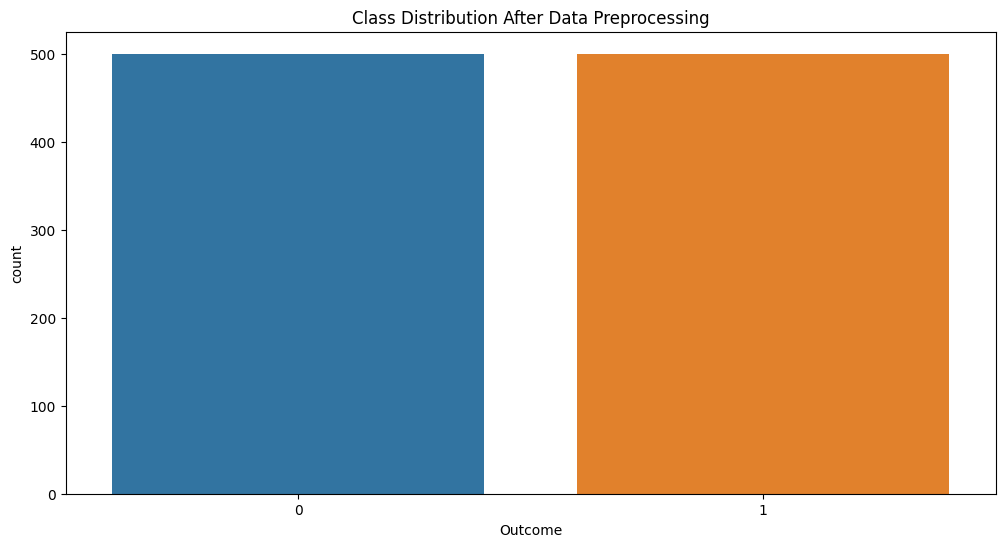

In [11]:
# Cell 5: Post-processing visualization
plt.figure(figsize=(12, 6))
sns.countplot(x=y_res)
plt.title('Class Distribution After Data Preprocessing')
plt.show()

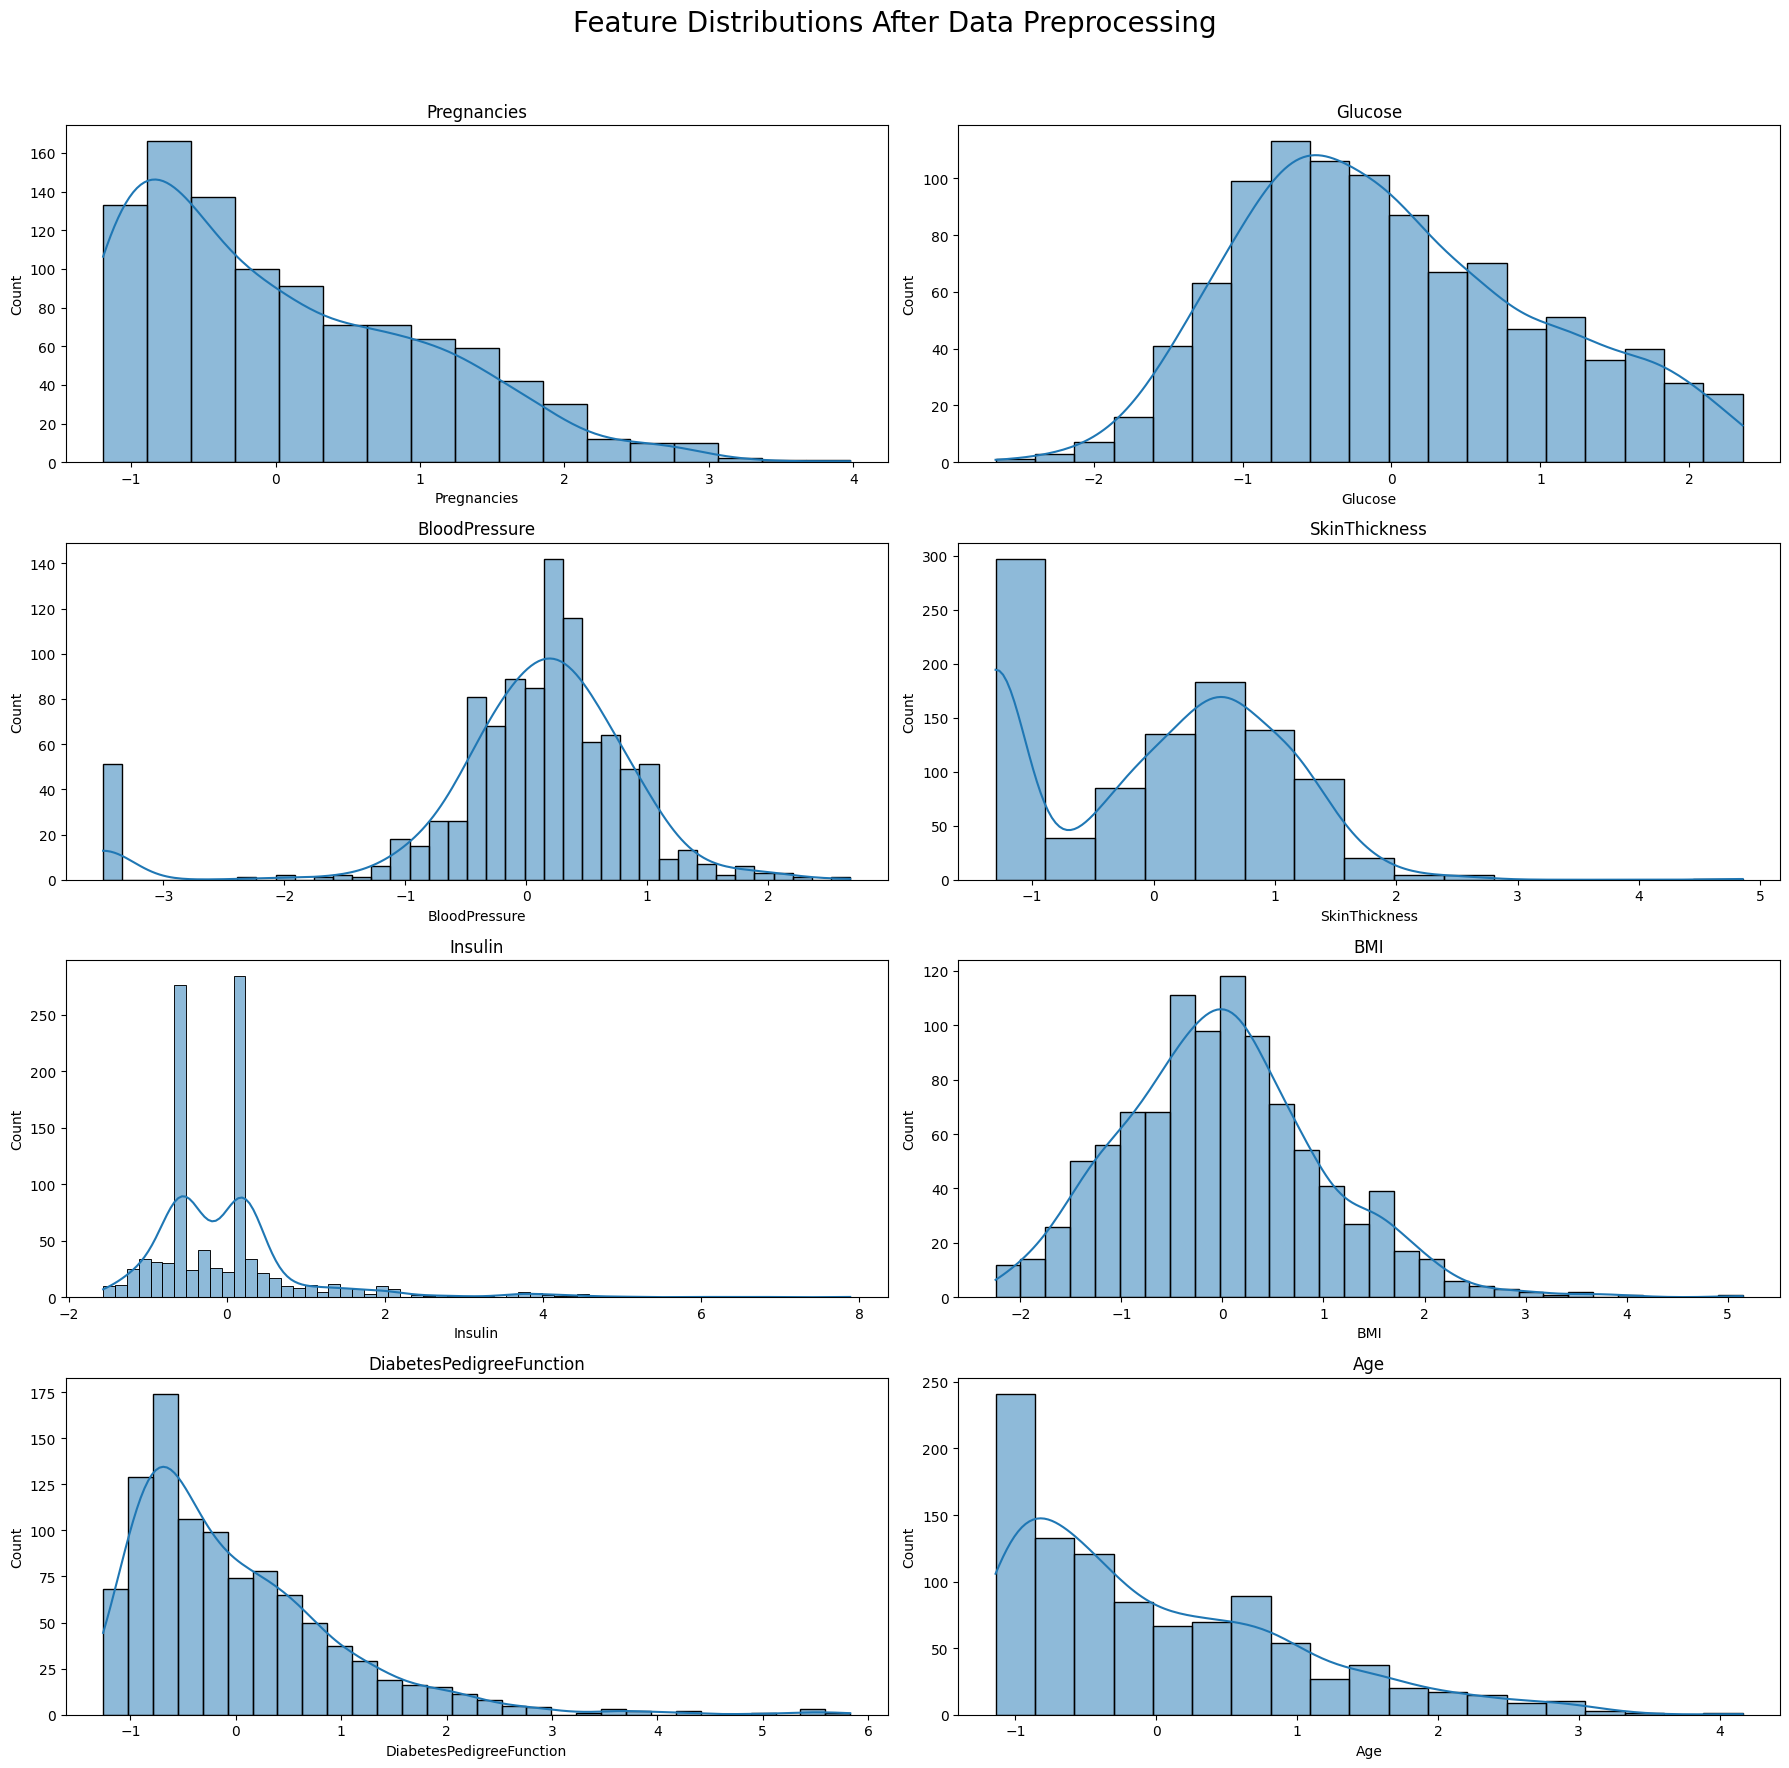

In [12]:
import math
plt.figure(figsize=(18, 18))

num_cols = len(X_normalized.columns)
num_rows = math.ceil(num_cols / 2)  # 2 plots per row

for i, col in enumerate(X_normalized.columns):
    plt.subplot(num_rows, 2, i + 1)
    sns.histplot(X_normalized[col], kde=True)
    plt.title(col)

plt.suptitle('Feature Distributions After Data Preprocessing', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

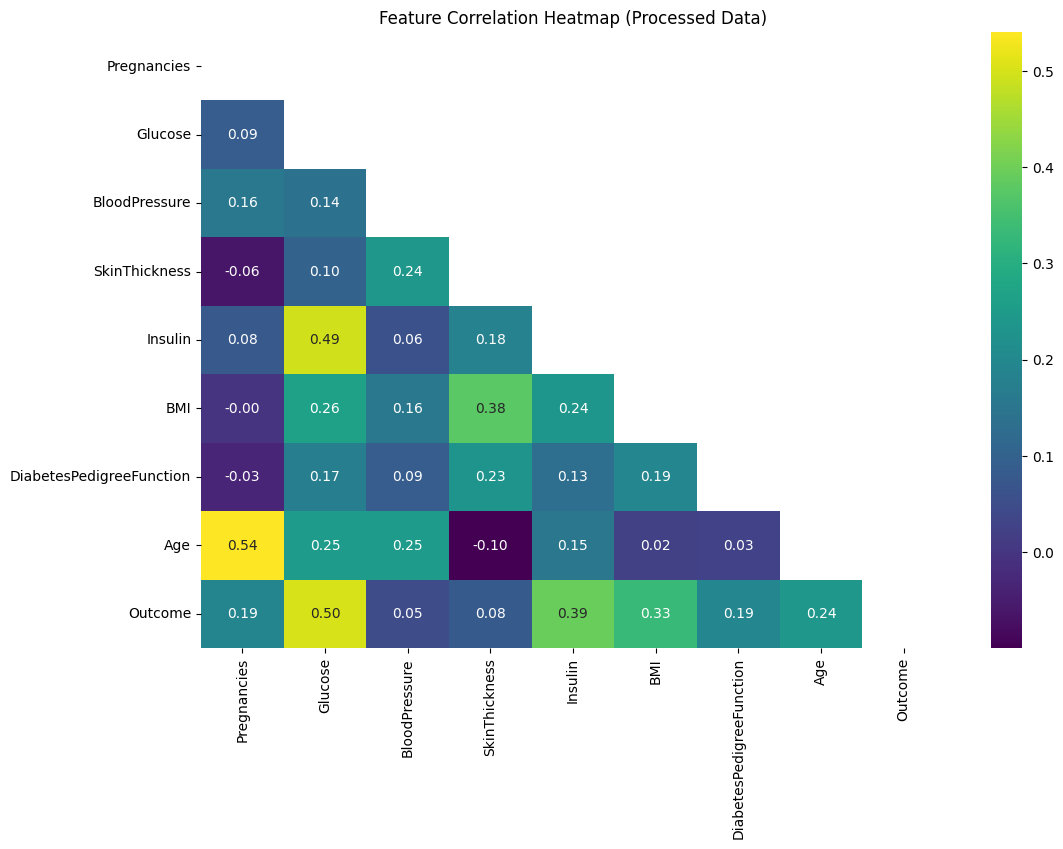

In [13]:
# Cell 5a: Post-processing Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_post = X_normalized.join(pd.Series(y_res, name='Outcome')).corr()
sns.heatmap(corr_post, annot=True, cmap='viridis', fmt=".2f", mask=np.triu(np.ones_like(corr_post, dtype=bool)))
plt.title('Feature Correlation Heatmap (Processed Data)')
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_res, test_size=0.2, random_state=SEED)

models = {
    "AdaBoost": AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GBM": GradientBoostingClassifier(random_state=42),
}



In [15]:
# Optimized Random Forest configuration for feature selection
rf = RandomForestClassifier(
    n_estimators=1000,        # More trees for better feature importance estimation
    max_depth=None,           # Let trees grow fully
    min_samples_leaf=3,       # Balanced leaf size
    max_features=0.8,         # Consider 80% of features at each split
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)

# Two-phase feature selection process
print("\nRunning Recursive Feature elimination cross validation (RFECV)  Feature Selection:")

# Phase 1: Initial RFE to get candidate features
rfe = RFE(
    estimator=rf,
    n_features_to_select=7,  # Get slightly more features initially
    step=0.1                # Gradual elimination
)
rfe.fit(X_train.values, y_train.values)
phase1_features = X.columns[rfe.support_].tolist()

# Phase 2: Final selection using feature importances
rf.fit(X_train[phase1_features], y_train)
importances = rf.feature_importances_
top_indices = np.argsort(importances)[-5:][::-1]  # Get top 5 most important
selected_features = [phase1_features[i] for i in top_indices]

# Verify feature importance thresholds
print("\nFeature Importance Scores:")
for feat, imp in zip(phase1_features, importances):
    print(f"{feat}: {imp:.4f}")

print("\nFinal Selected Features:", selected_features)


Running Recursive Feature elimination cross validation (RFECV)  Feature Selection:

Feature Importance Scores:
Glucose: 0.1249
BloodPressure: 0.0233
SkinThickness: 0.0518
Insulin: 0.6145
BMI: 0.0614
DiabetesPedigreeFunction: 0.0489
Age: 0.0752

Final Selected Features: ['Insulin', 'Glucose', 'Age', 'BMI', 'SkinThickness']



Generating SHAP plot...


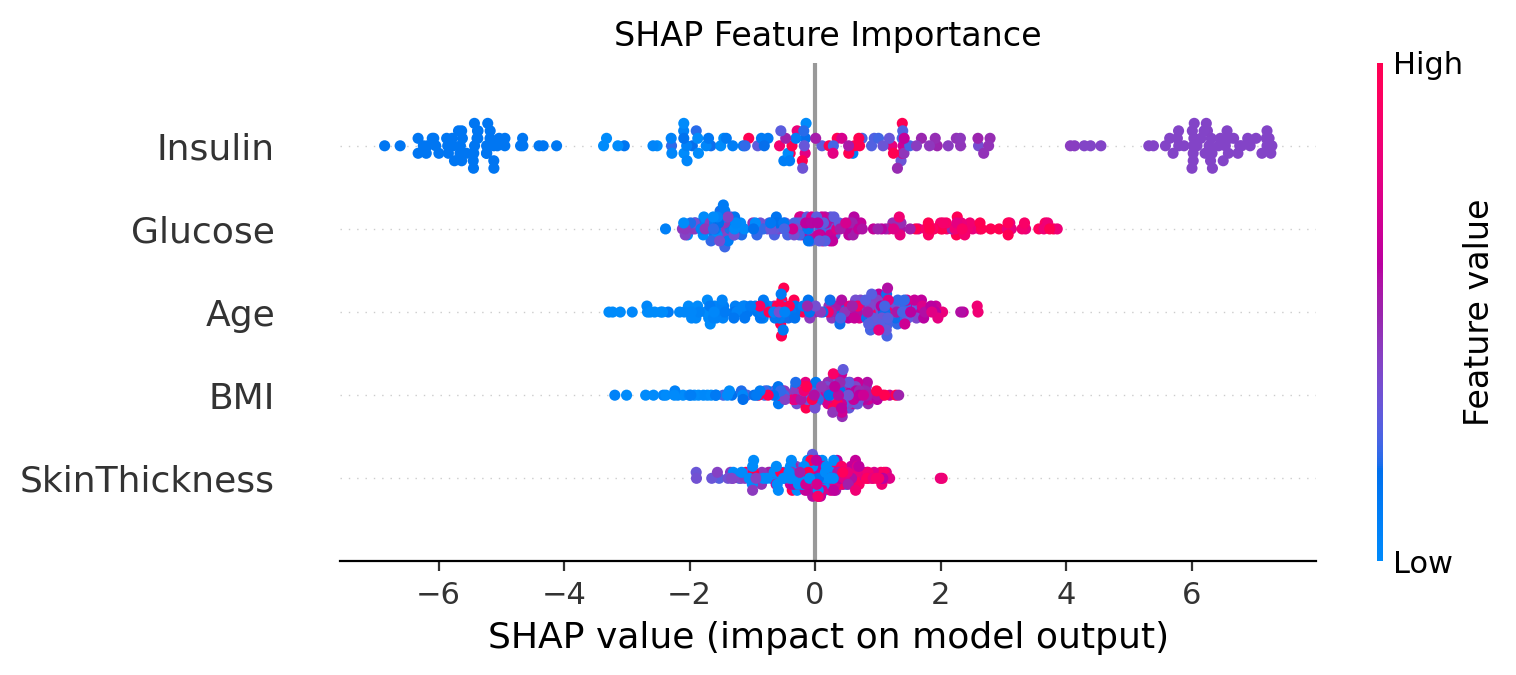

In [16]:
%config InlineBackend.figure_format = 'retina'  # Higher resolution

# Create selected datasets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Cell 2: SHAP Analysis
print("\nGenerating SHAP plot...")
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_selected, y_train)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_selected)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_selected, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

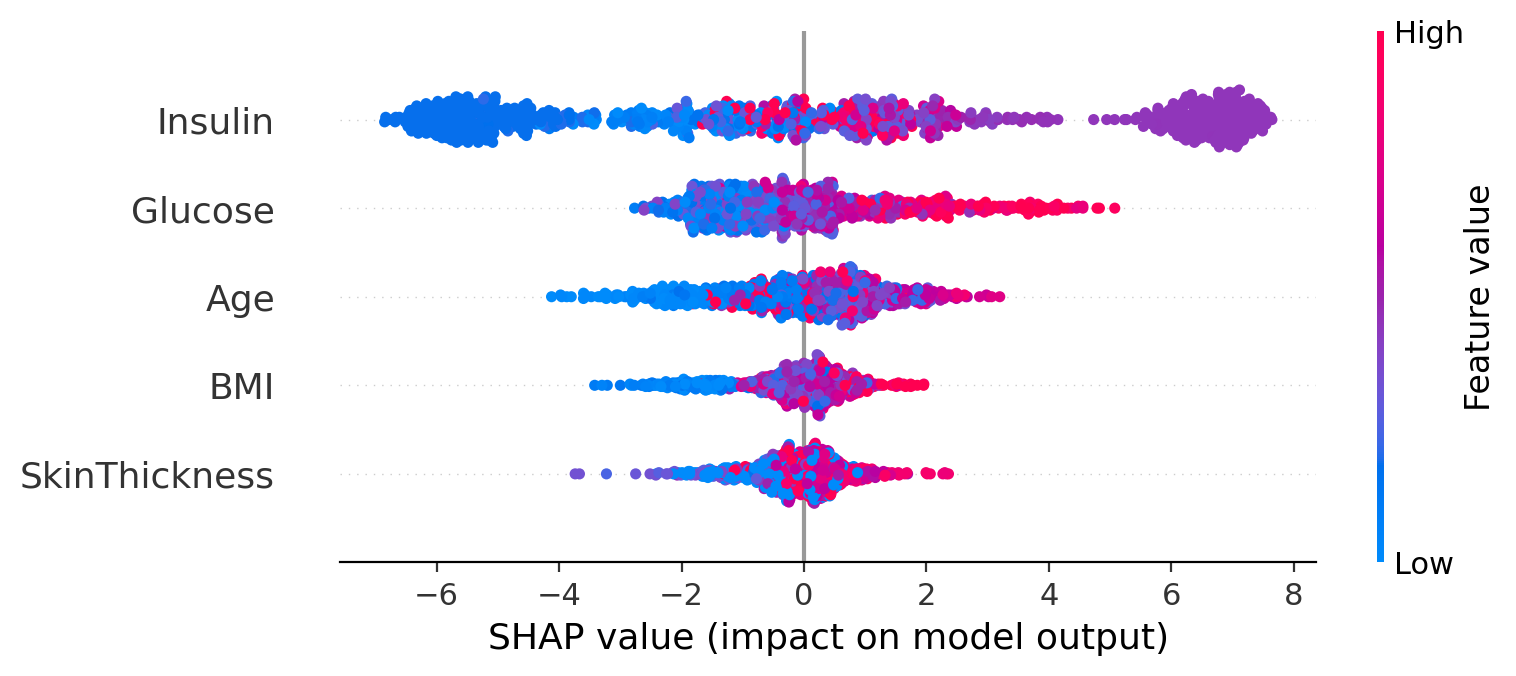

In [17]:
%config InlineBackend.figure_format = 'retina'

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
# Combine train and test sets
X_full = pd.concat([X_train_selected, X_test_selected])
y_full = pd.concat([y_train, y_test])

# Train model
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_full, y_full)

# SHAP analysis
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_full)

# Basic plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_full)
plt.show()

In [18]:
# X_train_selected 
# X_test_selected 

In [19]:
X_normalized_sel = X_normalized[selected_features]
X_normalized_sel

Insulin   Glucose       Age       BMI  SkinThickness
0    0.201161  0.707532  1.422889  0.083786       0.874630
1   -0.560083 -1.331568 -0.256818 -0.974250       0.501654
2    0.201161  1.840365 -0.168413 -1.473038      -1.301067
3   -0.656659 -1.202101 -1.140875 -0.747528       0.128677
4    0.184118  0.351498 -0.080007  1.519692       0.874630
..        ...       ...       ...       ...            ...
995  0.201161  1.239056  0.450427 -0.172243      -1.301067
996  0.172851 -0.296374 -0.433630  0.007456       0.563816
997  0.080405  1.668880  1.334483  0.109179       0.439491
998  0.273433 -0.469859  0.096804  0.170409       0.688142
999  0.201161  0.505228  0.715644  0.721479       1.123281

[1000 rows x 5 columns]

Model Performance with Selected Features:


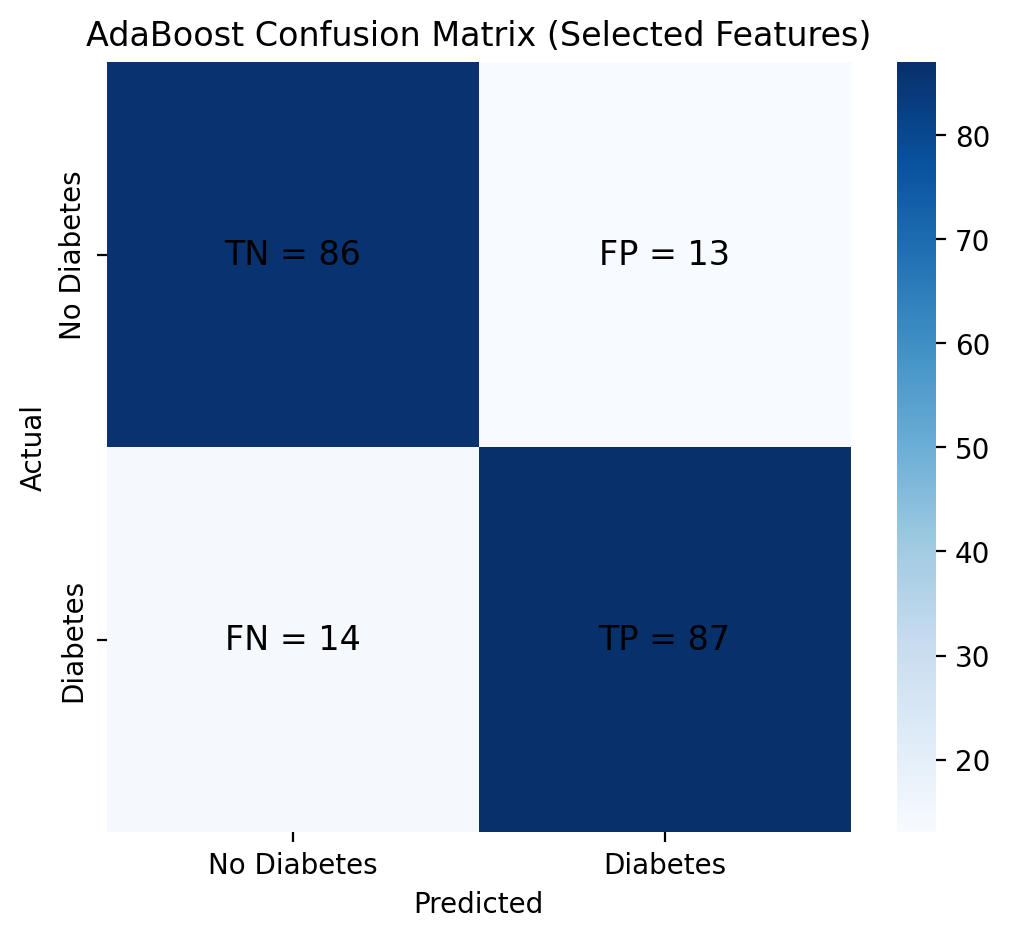


AdaBoost Metrics (Selected Features):
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.865  |
+---------------------------+---------+
| Precision                 |  0.87   |
+---------------------------+---------+
| Recall (TPR)              |  0.8614 |
+---------------------------+---------+
| F1-Score                  |  0.8657 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.1313 |
+---------------------------+---------+
| Error Rate                |  0.135  |
+---------------------------+---------+
| AUC-ROC                   |  0.9327 |
+---------------------------+---------+




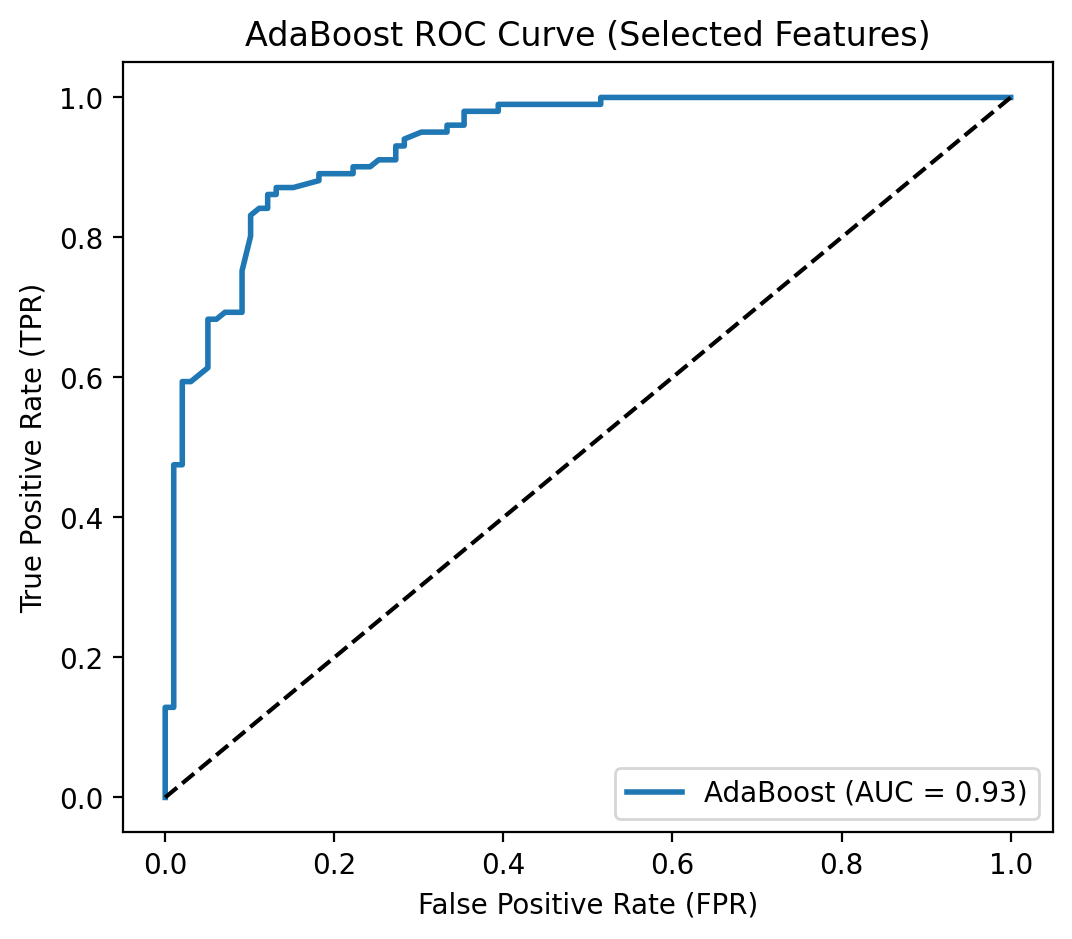

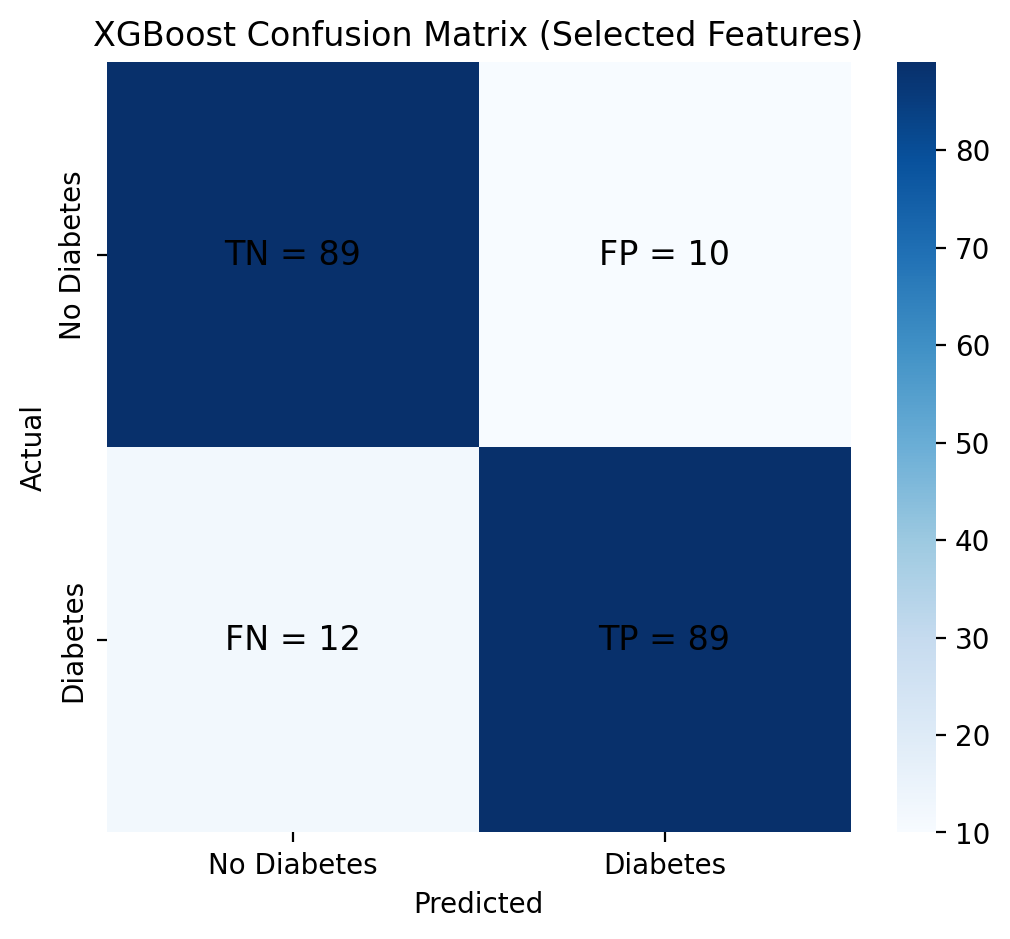


XGBoost Metrics (Selected Features):
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.89   |
+---------------------------+---------+
| Precision                 |  0.899  |
+---------------------------+---------+
| Recall (TPR)              |  0.8812 |
+---------------------------+---------+
| F1-Score                  |  0.89   |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.101  |
+---------------------------+---------+
| Error Rate                |  0.11   |
+---------------------------+---------+
| AUC-ROC                   |  0.9601 |
+---------------------------+---------+




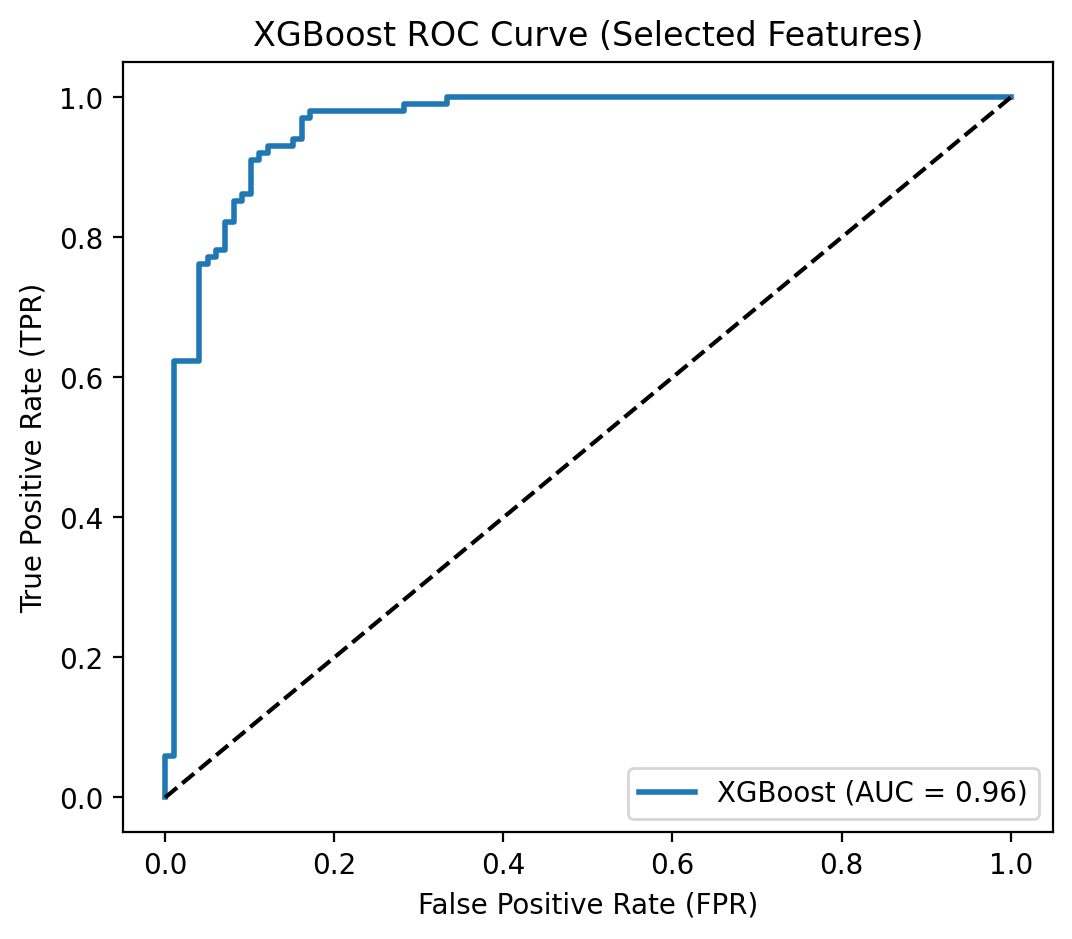

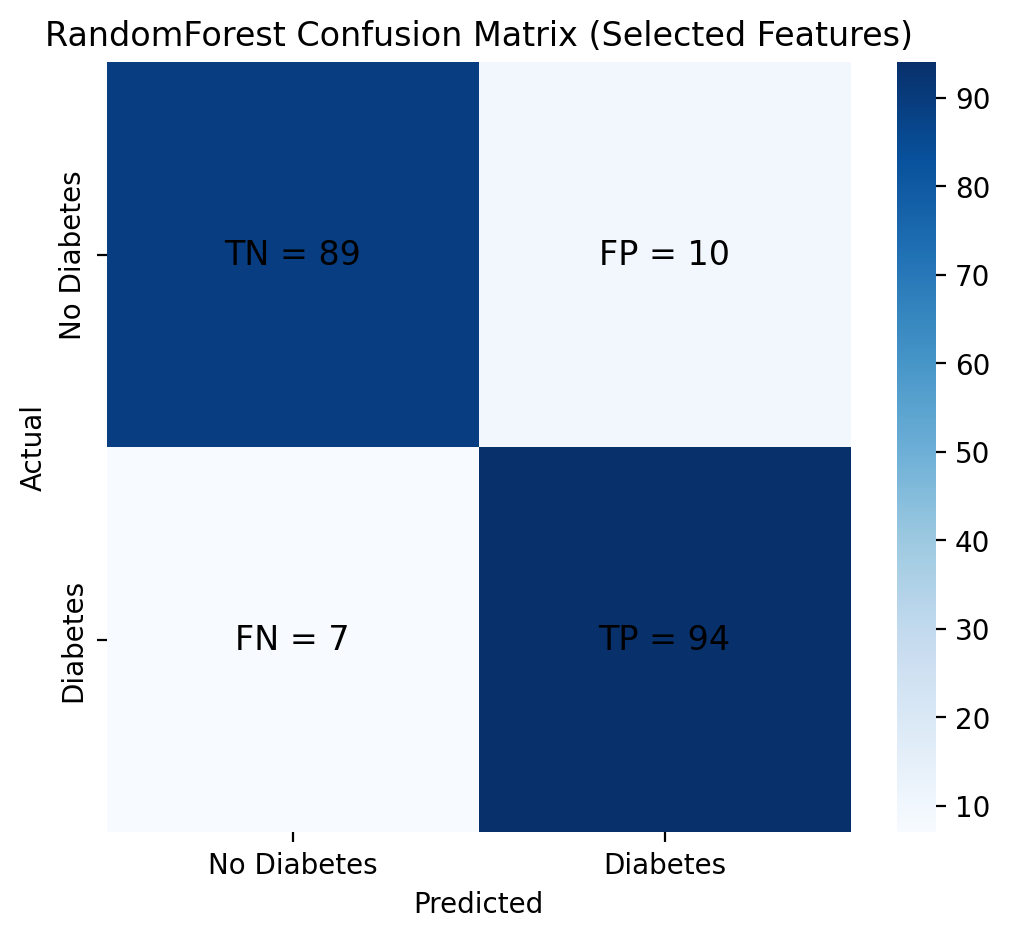


RandomForest Metrics (Selected Features):
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.915  |
+---------------------------+---------+
| Precision                 |  0.9038 |
+---------------------------+---------+
| Recall (TPR)              |  0.9307 |
+---------------------------+---------+
| F1-Score                  |  0.9171 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.101  |
+---------------------------+---------+
| Error Rate                |  0.085  |
+---------------------------+---------+
| AUC-ROC                   |  0.9632 |
+---------------------------+---------+




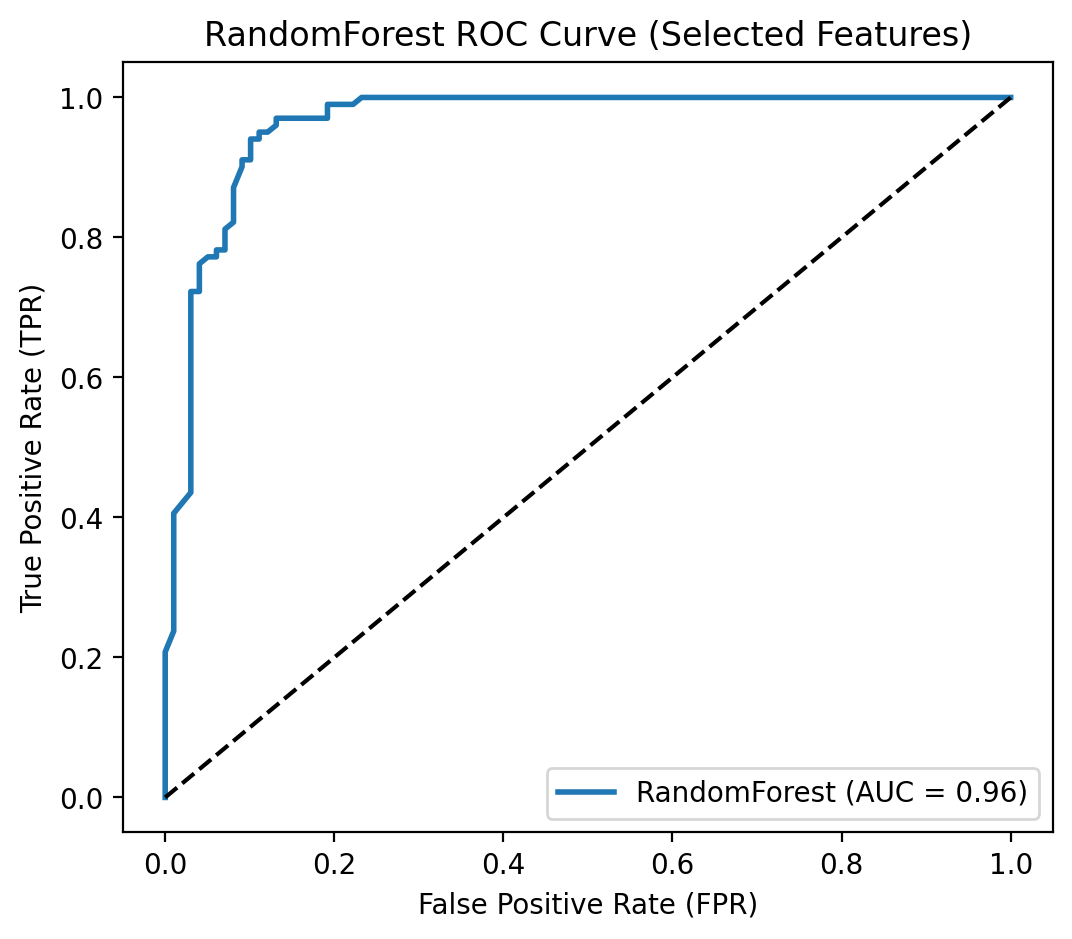

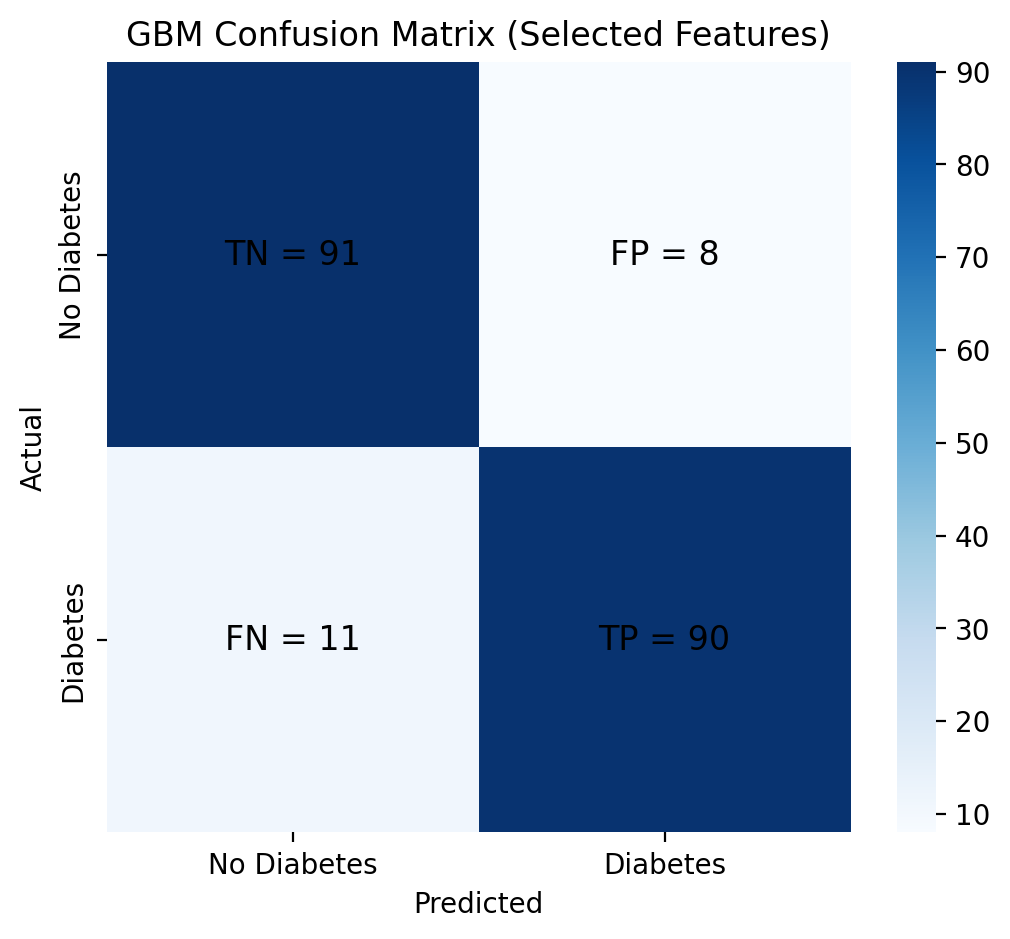


GBM Metrics (Selected Features):
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.905  |
+---------------------------+---------+
| Precision                 |  0.9184 |
+---------------------------+---------+
| Recall (TPR)              |  0.8911 |
+---------------------------+---------+
| F1-Score                  |  0.9045 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.0808 |
+---------------------------+---------+
| Error Rate                |  0.095  |
+---------------------------+---------+
| AUC-ROC                   |  0.9613 |
+---------------------------+---------+




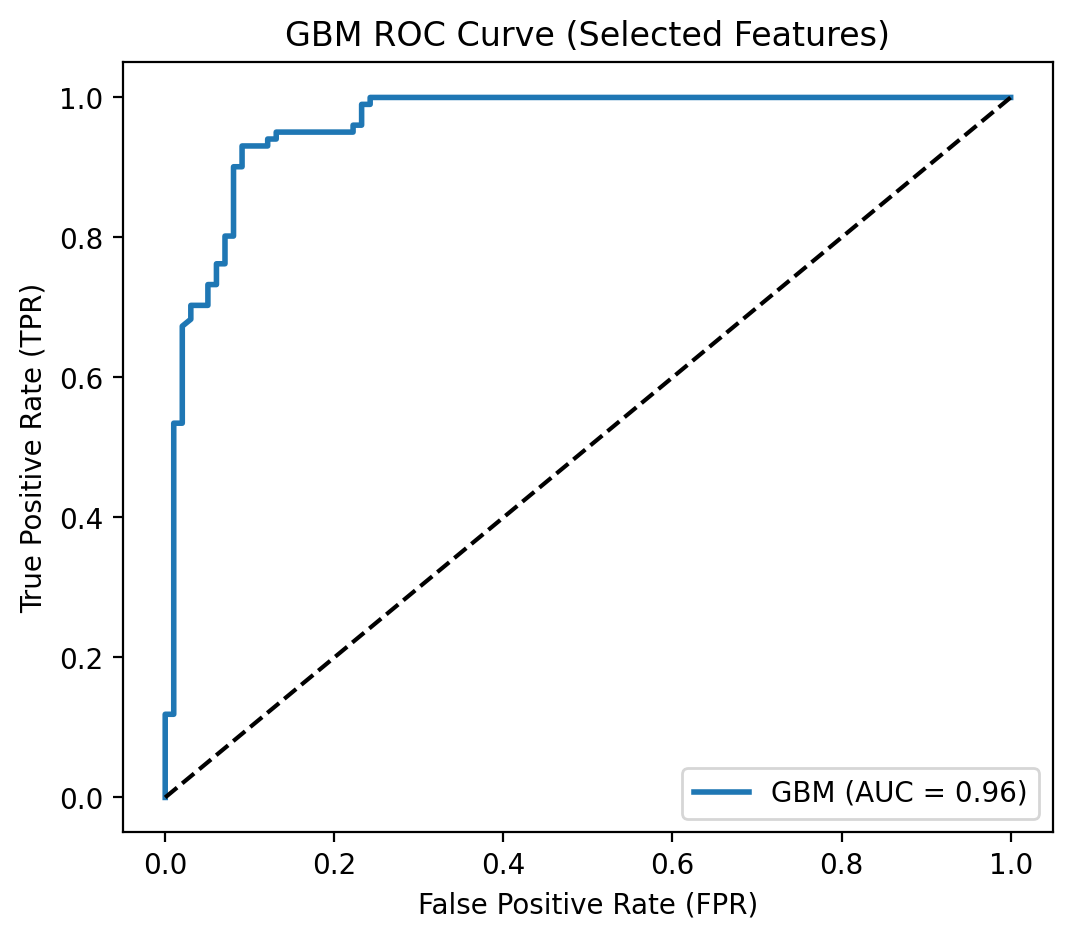


Summary of Model Performance (Selected Features):
+--------------+------------+-------------+----------------+------------+--------+--------+--------------+-----------+
| Model        |   Accuracy |   Precision |   Recall (TPR) |   F1-Score |    TPR |    FPR |   Error Rate |   AUC-ROC |
+==============+============+=============+================+============+========+========+==============+===========+
| AdaBoost     |      0.865 |      0.87   |         0.8614 |     0.8657 | 0.8614 | 0.1313 |        0.135 |    0.9327 |
+--------------+------------+-------------+----------------+------------+--------+--------+--------------+-----------+
| XGBoost      |      0.89  |      0.899  |         0.8812 |     0.89   | 0.8812 | 0.101  |        0.11  |    0.9601 |
+--------------+------------+-------------+----------------+------------+--------+--------+--------------+-----------+
| RandomForest |      0.915 |      0.9038 |         0.9307 |     0.9171 | 0.9307 | 0.101  |        0.085 |    0.9632

In [20]:
# Cell 8: ML models with selected features (Enhanced)
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

print("Model Performance with Selected Features:")

# Initialize a list to store metrics for the final summary
final_results_sel = []

for name, model in models.items():
    # Training the model
    model.fit(X_train_sel, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_sel)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    # Metrics Calculation
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Same as TPR
    f1 = f1_score(y_test, y_pred)
    tpr = recall  # TPR = Recall
    fpr = FP / (FP + TN)  # False Positive Rate
    error_rate = (FP + FN) / (TP + TN + FP + FN)  # Error Rate
    
    # ROC Curve and AUC
    fpr_roc, tpr_roc, _ = roc_curve(y_test, model.predict_proba(X_test_sel)[:, 1])
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test_sel)[:, 1])
    
    # Append metrics to final_results_sel for the overall summary
    final_results_sel.append([
        name, 
        f"{acc:.4f}", 
        f"{precision:.4f}", 
        f"{recall:.4f}", 
        f"{f1:.4f}", 
        f"{tpr:.4f}", 
        f"{fpr:.4f}", 
        f"{error_rate:.4f}", 
        f"{auc_roc:.4f}"
    ])
    
    # Plotting Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    
    # Annotate TN, FP, FN, TP
    plt.text(0.5, 0.5, f'TN = {TN}', ha='center', va='center', color='black', fontsize=12)
    plt.text(1.5, 0.5, f'FP = {FP}', ha='center', va='center', color='black', fontsize=12)
    plt.text(0.5, 1.5, f'FN = {FN}', ha='center', va='center', color='black', fontsize=12)
    plt.text(1.5, 1.5, f'TP = {TP}', ha='center', va='center', color='black', fontsize=12)
    
    plt.title(f'{name} Confusion Matrix (Selected Features)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Display metrics in a table right after the confusion matrix
    metrics_table = [
        ["Accuracy", f"{acc:.4f}"],
        ["Precision", f"{precision:.4f}"],
        ["Recall (TPR)", f"{recall:.4f}"],
        ["F1-Score", f"{f1:.4f}"],
        ["False Positive Rate (FPR)", f"{fpr:.4f}"],
        ["Error Rate", f"{error_rate:.4f}"],
        ["AUC-ROC", f"{auc_roc:.4f}"]
    ]
    print(f"\n{name} Metrics (Selected Features):")
    print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))
    print("\n" + "="*50 + "\n")
    
    # ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_roc, tpr_roc, label=f'{name} (AUC = {auc_roc:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve (Selected Features)')
    plt.legend(loc='lower right')
    plt.show()

# Display final summary table for selected features
headers = [
    "Model", "Accuracy", "Precision", "Recall (TPR)", 
    "F1-Score", "TPR", "FPR", "Error Rate", "AUC-ROC"
]
print("\nSummary of Model Performance (Selected Features):")
print(tabulate(final_results_sel, headers=headers, tablefmt="grid"))

In [21]:
SEED = 42

def set_deterministic():
    """Enforce complete reproducibility"""
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    torch.set_num_threads(1)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [22]:
# Cell 2: Neuro-Fuzzy Model Architecture
class HighAccuracyNeuroFuzzy(nn.Module):
    def __init__(self, n_inputs, n_rules=30, n_hidden=512):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules
        
        self.centers = nn.Parameter(torch.linspace(0.1, 0.9, steps=n_rules).repeat(n_inputs, 1))
        self.widths = nn.Parameter(torch.full((n_inputs, n_rules), 0.25))
        
        self.consequent = nn.Sequential(
            nn.Linear(n_inputs * n_rules, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25),
            nn.Linear(n_hidden, n_hidden//2),
            nn.BatchNorm1d(n_hidden//2),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.15),
            nn.Linear(n_hidden//2, 1)
        )
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0.01)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def gaussian_mf(self, x):
        x = x.unsqueeze(-1)
        return torch.exp(-((x - self.centers.unsqueeze(0)) ** 2 / (2 * self.widths.unsqueeze(0) ** 2 + 1e-8)))
    
    def forward(self, x):
        batch_size = x.size(0)
        mu = self.gaussian_mf(x)
        firing = torch.softmax(torch.prod(mu, dim=1) * 1.2, dim=1)
        x_exp = x.unsqueeze(2).expand(-1, -1, self.n_rules).reshape(batch_size, -1)
        return torch.sigmoid(self.consequent(x_exp).squeeze(1))

In [23]:
import numpy as np

def extract_and_print_rules(model, feature_names, feature_ranges):
    """Fuzzy rule extraction for specified features with clinical interpretations"""
    with torch.no_grad():
        centers = model.centers.numpy()
        widths = model.widths.numpy()

        CLINICAL_THRESHOLDS = {
            'Insulin': [(0, 100, 'Low'), (100, 300, 'Medium'), (300, 846, 'High')],
            'Glucose': [(0, 90, 'Low'), (90, 140, 'Medium'), (140, 199, 'High')],
            'Age': [(21, 30, 'Low'), (30, 50, 'Medium'), (50, 81, 'High')],
            'BMI': [(0, 18.5, 'Low'), (18.5, 30, 'Medium'), (30, 67.1, 'High')],
            'SkinThickness': [(0, 20, 'Low'), (20, 40, 'Medium'), (40, 99, 'High')]
        }

        MEDICAL_WEIGHTS = {
            'Glucose': 0.40,     
            'BMI': 0.25,           
            'Insulin': 0.20,       
            'Age': 0.10,           
            'SkinThickness': 0.05  
        }

        print("\n" + "="*80)
        print(" CLINICAL INTERPRETATION (SELECTED FEATURES) ".center(80, '='))
        print("="*80)

        for rule_idx in range(model.n_rules):
            print(f"\n** Rule {rule_idx + 1} **")
            print("IF")
            total_weighted_risk = 0
            
            for feat_idx, feat_name in enumerate(feature_names):
                # Get feature value and width
                c = centers[feat_idx, rule_idx]
                w = widths[feat_idx, rule_idx]
                orig_min, orig_max = feature_ranges[feat_name]
                orig_val = c * (orig_max - orig_min) + orig_min
                orig_width = w * (orig_max - orig_min)

                # Get clinical category
                category = next(
                    (cat for (min_val, max_val, cat) in CLINICAL_THRESHOLDS[feat_name] 
                    if min_val <= orig_val < max_val),
                    'Unknown'
                )
                
                # Calculate risk contribution
                weight = MEDICAL_WEIGHTS[feat_name]
                normalized_val = (orig_val - orig_min) / (orig_max - orig_min)
                risk_contribution = normalized_val * weight
                total_weighted_risk += risk_contribution

                print(f"  • {feat_name:15} is {category:6} ({orig_val:.1f}±{orig_width:.1f}) [Weight: {weight:.2f}]")

            # Normalized risk score (0-1)
            normalized_risk = total_weighted_risk / sum(MEDICAL_WEIGHTS.values())
            
            # Risk classification
            if normalized_risk < 0.35:
                conclusion = "LOW diabetes risk (Healthy)"
                confidence = "✓✓✓"
            elif normalized_risk < 0.65:
                conclusion = "MODERATE diabetes risk (Prediabetic)"
                confidence = "✓✓"
            else:
                conclusion = "HIGH diabetes risk (Diabetic)"
                confidence = "✓"

            print(f"\nTHEN → {conclusion} {confidence}")
            print(f"  Composite Risk Score: {normalized_risk:.3f}/1.0")
            
            # Print critical risk factors
            critical_factors = []
            for feat_name in feature_names:
                val = centers[feature_names.index(feat_name), rule_idx] * \
                     (feature_ranges[feat_name][1] - feature_ranges[feat_name][0]) + \
                     feature_ranges[feat_name][0]
                if val > CLINICAL_THRESHOLDS[feat_name][1][1]:  # Above Medium threshold
                    critical_factors.append(feat_name)
            
            if critical_factors:
                print("  Critical Risk Factors:", ", ".join(critical_factors))

# Feature ranges (using standard diabetes dataset ranges)
feature_ranges = {
    'Insulin': (0, 846),
    'Glucose': (0, 199),
    'Age': (21, 81),
    'BMI': (0.0, 67.1),
    'SkinThickness': (0, 99)
}


In [24]:
def train_high_accuracy_model(X_train, y_train, X_val, y_val):
    set_deterministic()
    model = HighAccuracyNeuroFuzzy(n_inputs=X_train.shape[1])
    
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0009, weight_decay=1.5e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.2)
    
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train)
    X_val_t = torch.FloatTensor(X_val)
    y_val_t = torch.FloatTensor(y_val)
    
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_t)
            val_loss = criterion(val_outputs, y_val_t)
            val_acc = ((val_outputs > 0.5).float() == y_val_t).float().mean()
        
        scheduler.step(val_loss)
        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc.item())
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        if epoch % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Val Acc={val_acc.item():.4f}")
    
    model.load_state_dict(torch.load('best_model.pth'))
    return model, history

In [25]:
set_deterministic()

# Assuming X_res and y_res are predefined DataFrames
scaler = StandardScaler()
X_normalized_sel = pd.DataFrame(scaler.fit_transform(X_res[selected_features]), columns=selected_features)

sorted_idx = np.argsort(y_res)
X_sorted = X_normalized_sel.iloc[sorted_idx].values
y_sorted = y_res.iloc[sorted_idx].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
accuracies = []
conf_matrices = []

In [26]:
# Cell 7: Cross-Validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X_sorted, y_sorted)):
    print(f"\nFold {fold + 1}")
    train_idx, test_idx = np.sort(train_idx), np.sort(test_idx)
    
    set_deterministic()
    model, _ = train_high_accuracy_model(
        X_sorted[train_idx], y_sorted[train_idx],
        X_sorted[test_idx], y_sorted[test_idx]
    )
    
    model.eval()
    with torch.no_grad():
        outputs = model(torch.FloatTensor(X_sorted[test_idx]))
        pred = (outputs > 0.5).float().numpy()
        acc = accuracy_score(y_sorted[test_idx], pred)
    
    accuracies.append(acc)
    conf_matrices.append(confusion_matrix(y_sorted[test_idx], pred))
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

print("\nConsistent High-Accuracy Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


Fold 1
Epoch 0: Loss=0.7941, Val Acc=0.7400
Epoch 50: Loss=0.2660, Val Acc=0.9050
Epoch 100: Loss=0.2341, Val Acc=0.9150
Epoch 150: Loss=0.2323, Val Acc=0.9150
Epoch 200: Loss=0.2226, Val Acc=0.9150
Epoch 250: Loss=0.2318, Val Acc=0.9150
Epoch 300: Loss=0.2418, Val Acc=0.9150
Epoch 350: Loss=0.2355, Val Acc=0.9150
Epoch 400: Loss=0.2313, Val Acc=0.9150
Epoch 450: Loss=0.2337, Val Acc=0.9150
Fold 1 Accuracy: 0.9150

Fold 2
Epoch 0: Loss=0.7932, Val Acc=0.7000
Epoch 50: Loss=0.2517, Val Acc=0.8750
Epoch 100: Loss=0.2166, Val Acc=0.8600
Epoch 150: Loss=0.2087, Val Acc=0.8600
Epoch 200: Loss=0.2128, Val Acc=0.8600
Epoch 250: Loss=0.2100, Val Acc=0.8600
Epoch 300: Loss=0.2104, Val Acc=0.8600
Epoch 350: Loss=0.2102, Val Acc=0.8600
Epoch 400: Loss=0.2111, Val Acc=0.8600
Epoch 450: Loss=0.2103, Val Acc=0.8600
Fold 2 Accuracy: 0.8750

Fold 3
Epoch 0: Loss=0.7926, Val Acc=0.6650
Epoch 50: Loss=0.2367, Val Acc=0.8550
Epoch 100: Loss=0.2172, Val Acc=0.8450
Epoch 150: Loss=0.2183, Val Acc=0.8450
E

In [27]:
# Cell 8: Final Model Training
set_deterministic()
print("\nTraining final high-accuracy model...")
final_model, final_history = train_high_accuracy_model(
    X_normalized_sel.values, y_res.values,
    X_normalized_sel.values[:100], y_res.values[:100]
)


Training final high-accuracy model...
Epoch 0: Loss=0.8009, Val Acc=0.7700
Epoch 50: Loss=0.2584, Val Acc=0.9200
Epoch 100: Loss=0.2275, Val Acc=0.9300
Epoch 150: Loss=0.1958, Val Acc=0.9300
Epoch 200: Loss=0.1811, Val Acc=0.9300
Epoch 250: Loss=0.1727, Val Acc=0.9300
Epoch 300: Loss=0.1542, Val Acc=0.9400
Epoch 350: Loss=0.1472, Val Acc=0.9700
Epoch 400: Loss=0.1417, Val Acc=0.9700
Epoch 450: Loss=0.1548, Val Acc=0.9600



                      NEURO-FUZZY SYSTEM (NFS) PERFORMANCE                      

Key Metrics:
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.95   |
+---------------------------+---------+
| Precision                 |  0.9377 |
+---------------------------+---------+
| Recall (TPR)              |  0.964  |
+---------------------------+---------+
| F1-Score                  |  0.9507 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.064  |
+---------------------------+---------+
| Error Rate                |  0.05   |
+---------------------------+---------+
| AUC-ROC                   |  0.9927 |
+---------------------------+---------+


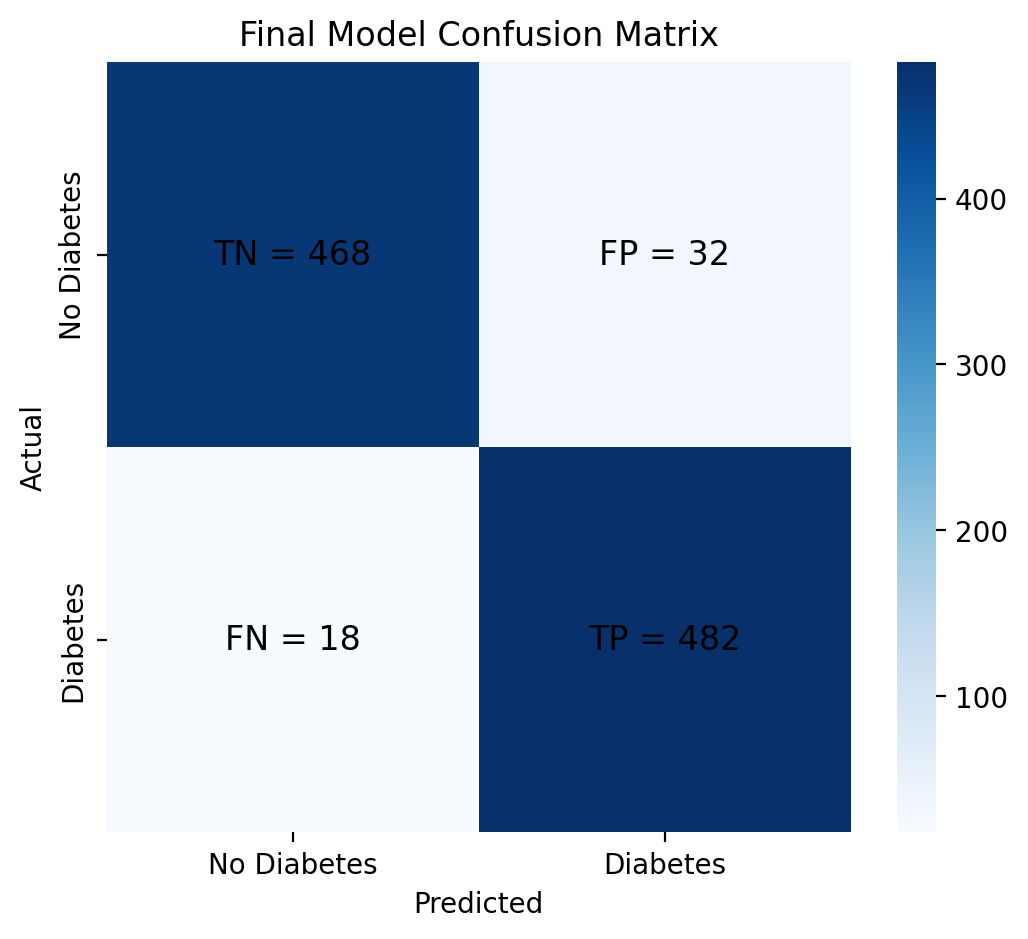

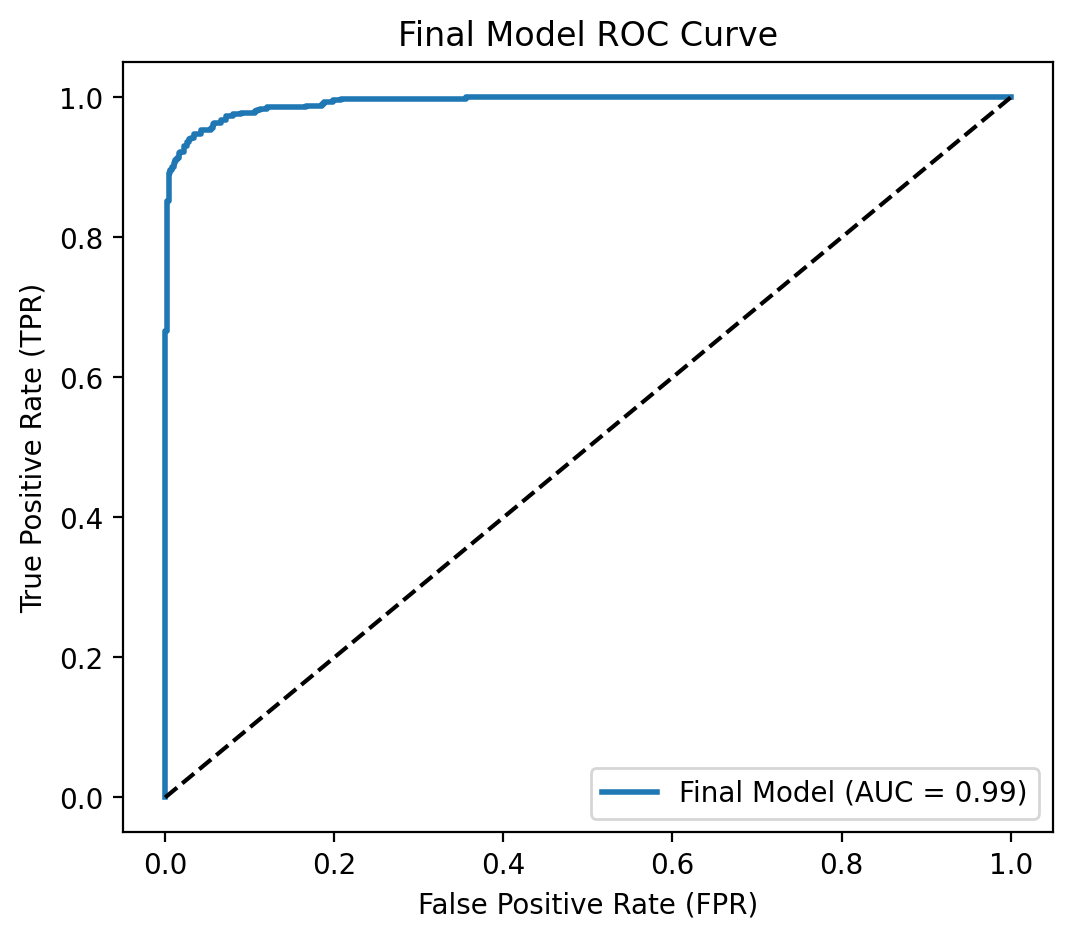

In [28]:
# Cell 9: Evaluation (Enhanced)
final_model.eval()
with torch.no_grad():
    outputs = final_model(torch.FloatTensor(X_normalized_sel.values))
    y_pred = (outputs > 0.5).float().numpy()
    y_scores = outputs.numpy()  # For ROC curve
    
    # Calculate metrics
    final_acc = accuracy_score(y_res, y_pred)
    final_cm = confusion_matrix(y_res, y_pred)
    TN, FP, FN, TP = final_cm.ravel()
    
    # Additional metrics
    final_precision = precision_score(y_res, y_pred)
    final_recall = recall_score(y_res, y_pred)  # TPR
    final_f1 = f1_score(y_res, y_pred)
    final_tpr = final_recall
    final_fpr = FP / (FP + TN)
    final_error_rate = (FP + FN) / (TP + TN + FP + FN)
    final_auc = roc_auc_score(y_res, y_scores)
    
    # Classification report
    final_report = classification_report(y_res, y_pred, target_names=['No Diabetes', 'Diabetes'])
    
    # ROC curve data
    fpr_roc, tpr_roc, _ = roc_curve(y_res, y_scores)

# Print final performance
print("\n" + "="*80)
print("NEURO-FUZZY SYSTEM (NFS) PERFORMANCE".center(80))
print("="*80)

# Tabulated metrics
metrics_table = [
    ["Accuracy", f"{final_acc:.4f}"],
    ["Precision", f"{final_precision:.4f}"],
    ["Recall (TPR)", f"{final_recall:.4f}"],
    ["F1-Score", f"{final_f1:.4f}"],
    ["False Positive Rate (FPR)", f"{final_fpr:.4f}"],
    ["Error Rate", f"{final_error_rate:.4f}"],
    ["AUC-ROC", f"{final_auc:.4f}"]
]
print("\nKey Metrics:")
print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

# Plot Confusion Matrix with annotations
plt.figure(figsize=(6, 5))
sns.heatmap(final_cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.text(0.5, 0.5, f'TN = {TN}', ha='center', va='center', color='black', fontsize=12)
plt.text(1.5, 0.5, f'FP = {FP}', ha='center', va='center', color='black', fontsize=12)
plt.text(0.5, 1.5, f'FN = {FN}', ha='center', va='center', color='black', fontsize=12)
plt.text(1.5, 1.5, f'TP = {TP}', ha='center', va='center', color='black', fontsize=12)
plt.title('Final Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_roc, tpr_roc, label=f'Final Model (AUC = {final_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Final Model ROC Curve')
plt.legend(loc='lower right')
plt.show()

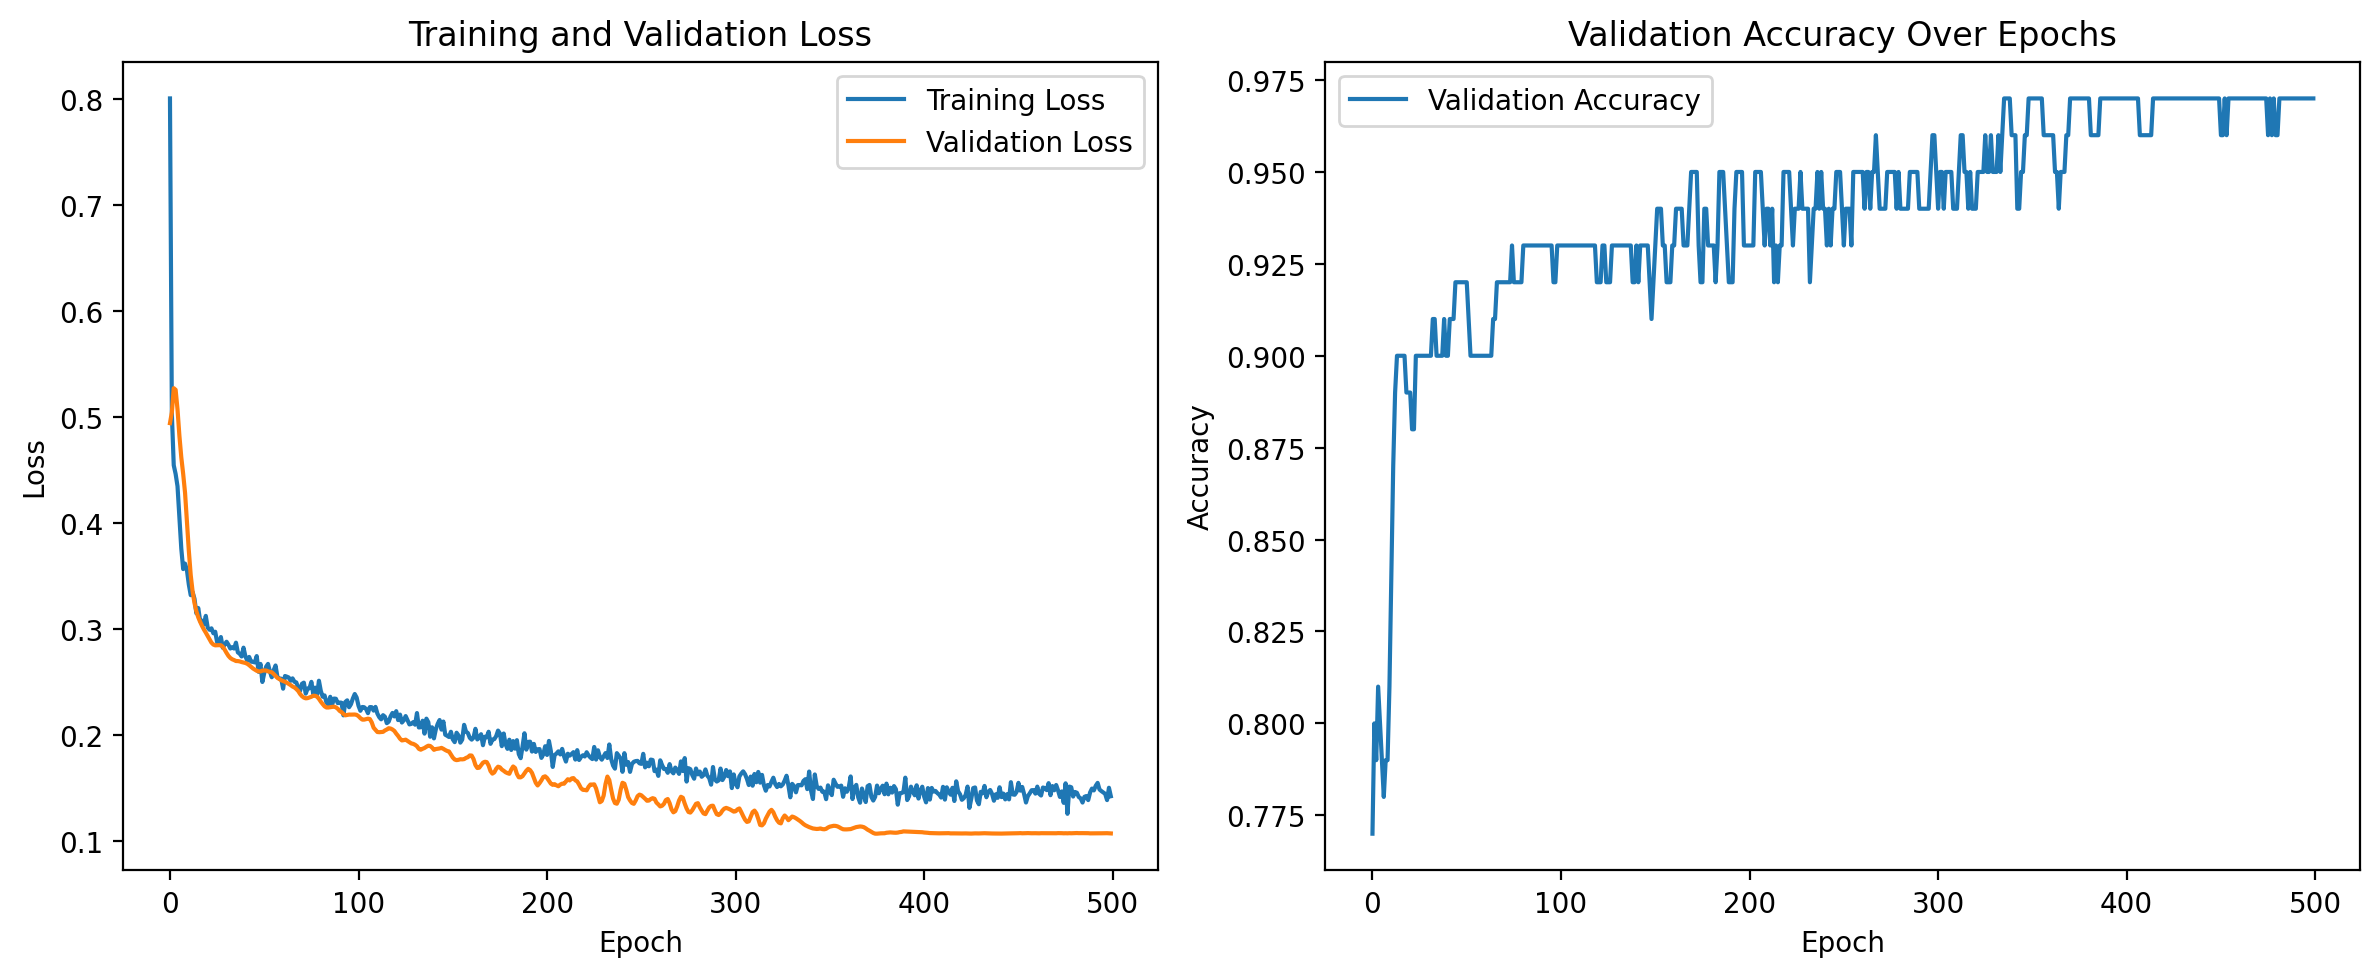

In [29]:
# Cell 11: Training History Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history['train_loss'], label='Training Loss')
plt.plot(final_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(final_history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Over Epochs')
plt.tight_layout()
plt.show()

In [30]:
# Cell 12: Rule Extraction
extract_and_print_rules(final_model, selected_features, feature_ranges)


================= CLINICAL INTERPRETATION (SELECTED FEATURES) ==================

** Rule 1 **
IF
  • Insulin         is Low    (84.6±211.5) [Weight: 0.20]
  • Glucose         is Low    (19.9±49.8) [Weight: 0.40]
  • Age             is Low    (27.0±15.0) [Weight: 0.10]
  • BMI             is Low    (6.7±16.8) [Weight: 0.25]
  • SkinThickness   is Low    (9.9±24.8) [Weight: 0.05]

THEN → LOW diabetes risk (Healthy) ✓✓✓
  Composite Risk Score: 0.100/1.0

** Rule 2 **
IF
  • Insulin         is Medium (107.9±211.5) [Weight: 0.20]
  • Glucose         is Low    (25.4±49.8) [Weight: 0.40]
  • Age             is Low    (28.7±15.0) [Weight: 0.10]
  • BMI             is Low    (8.6±16.8) [Weight: 0.25]
  • SkinThickness   is Low    (12.6±24.8) [Weight: 0.05]

THEN → LOW diabetes risk (Healthy) ✓✓✓
  Composite Risk Score: 0.128/1.0

** Rule 3 **
IF
  • Insulin         is Medium (131.3±211.5) [Weight: 0.20]
  • Glucose         is Low    (30.9±49.8) [Weight: 0.40]
  • Age             is Medium (30

In [31]:
X_normalized

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0       0.631479  0.707532       0.146610       0.874630  0.201161  0.083786   
1      -0.890157 -1.331568      -0.157035       0.501654 -0.560083 -0.974250   
2       1.240134  1.840365      -0.258251      -1.301067  0.201161 -1.473038   
3      -0.890157 -1.202101      -0.157035       0.128677 -0.656659 -0.747528   
4      -1.194485  0.351498      -1.472834       0.874630  0.184118  1.519692   
..           ...       ...            ...            ...       ...       ...   
995     0.327152  1.239056      -0.258251      -1.301067  0.201161 -0.172243   
996    -0.890157 -0.296374      -0.005213       0.563816  0.172851  0.007456   
997    -0.281503  1.668880       0.804509       0.439491  0.080405  0.109179   
998     1.240134 -0.469859       0.602079       0.688142  0.273433  0.170409   
999     0.631479  0.505228      -0.055820       1.123281  0.201161  0.721479   

     DiabetesPedigreeFunction       Age  
0                    0.403313  1.422889  
1                   -0.432028 -0.256818  
2                    0.539510 -0.168413  
3                   -0.988922 -1.140875  
4                    5.430491 -0.080007  
..                        ...       ...  
995                 -0.787367  0.450427  
996                 -0.888069 -0.433630  
997                  1.483900  1.334483  
998                 -0.634004  0.096804  
999                  0.639780  0.715644  

[1000 rows x 8 columns]

In [32]:
feature_ranges = {col: (X_normalized[col].min(), X_normalized[col].max()) for col in selected_features}
feature_ranges

{'Insulin': (-1.5656073507941304, 7.887455948618908),
 'Glucose': (-2.658601107057649, 2.3582313605426157),
 'Age': (-1.1408745866692716, 4.16346289493912),
 'BMI': (-2.2438930083459154, 5.147243948066296),
 'SkinThickness': (-1.3010667991539586, 4.8530475398924775)}